In [ ]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2  # Import OpenCV for resizing spectrograms


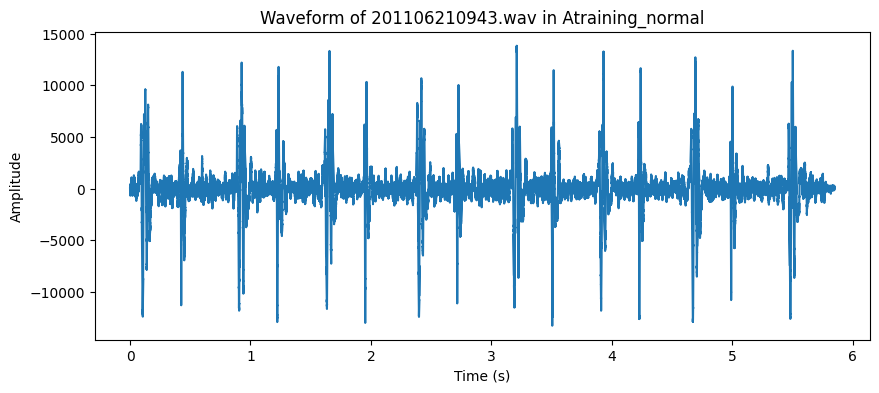

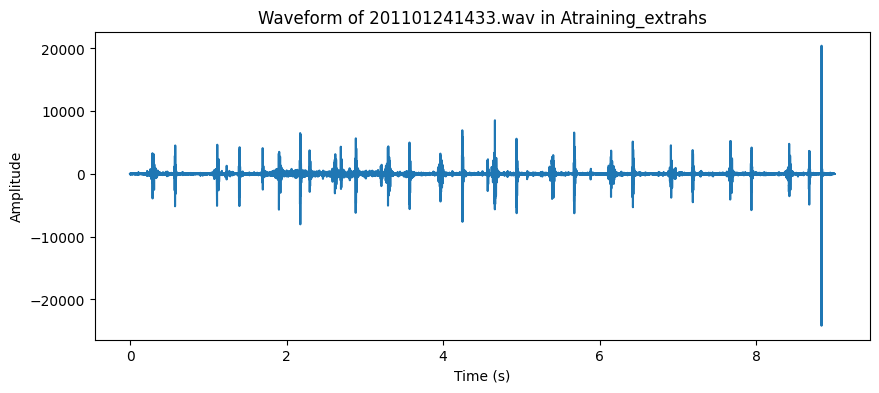

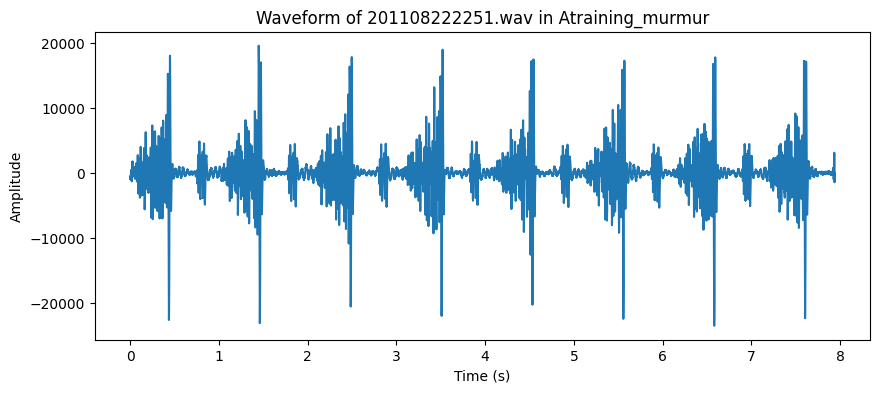

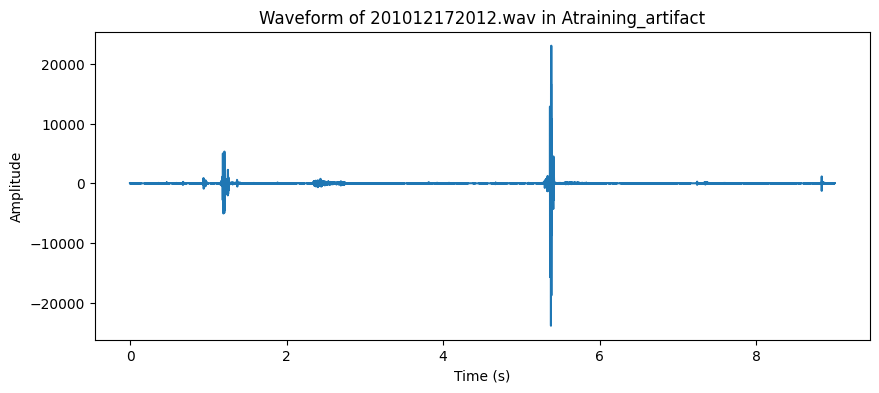

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import wave

# Dictionary containing file names and their corresponding labels
file_label_dict = {
    "201106210943.wav": "Atraining_normal",
    "201101241433.wav": "Atraining_extrahs",
    "201108222251.wav": "Atraining_murmur",
    "201012172012.wav": "Atraining_artifact"
}

def plot_wav_file(file_name, label, base_folder="/content/drive/MyDrive/class_folder"):
    """
    Plots the wave file from the specified label folder.

    :param file_name: Name of the .wav file
    :param label: Label of the folder where the file is located
    :param base_folder: Name of the base folder containing label folders
    """
    file_path = os.path.join(base_folder, label, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {file_name} not found in {label} folder.")
        return

    # Open the wav file
    with wave.open(file_path, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = wav_file.readframes(-1)
        signal = np.frombuffer(signal, dtype="int16")

        # Get time from frames
        frame_rate = wav_file.getframerate()
        time = np.linspace(0, len(signal) / frame_rate, num=len(signal))

        # Plotting the wav file
        plt.figure(figsize=(10, 4))
        plt.title(f"Waveform of {file_name} in {label}")
        plt.plot(time, signal)
        plt.ylabel("Amplitude")
        plt.xlabel("Time (s)")
        plt.show()

# Plotting each file
for file_name, label in file_label_dict.items():
    plot_wav_file(file_name, label)


Epoch 1/20
3/3 [==============================] - 1s 88ms/step - loss: 3.0513 - accuracy: 0.4719 - val_loss: 7.6710 - val_accuracy: 0.4000
Epoch 2/20
3/3 [==============================] - 0s 19ms/step - loss: 8.8627 - accuracy: 0.4494 - val_loss: 9.8513 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 0s 18ms/step - loss: 5.4855 - accuracy: 0.5506 - val_loss: 8.6349 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 0s 17ms/step - loss: 3.8640 - accuracy: 0.5506 - val_loss: 2.4717 - val_accuracy: 0.8000
Epoch 5/20
3/3 [==============================] - 0s 18ms/step - loss: 1.8370 - accuracy: 0.6742 - val_loss: 1.8598 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 0s 28ms/step - loss: 1.0377 - accuracy: 0.7528 - val_loss: 1.8138 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 0s 22ms/step - loss: 0.5185 - accuracy: 0.7753 - val_loss: 0.8998 - val_accuracy: 0.5000
Epoch 8/20
3/3 [===========

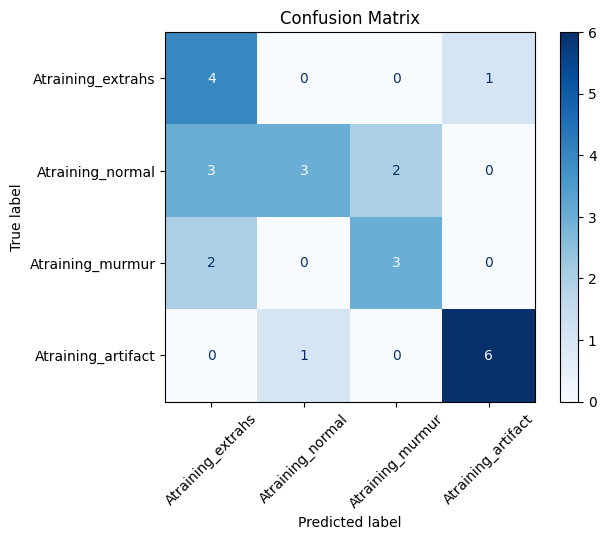

Classification Report:
                     precision    recall  f1-score   support

 Atraining_extrahs       0.44      0.80      0.57         5
  Atraining_normal       0.75      0.38      0.50         8
  Atraining_murmur       0.60      0.60      0.60         5
Atraining_artifact       0.86      0.86      0.86         7

          accuracy                           0.64        25
         macro avg       0.66      0.66      0.63        25
      weighted avg       0.69      0.64      0.63        25



In [ ]:
# using STFT
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def extract_features(file_path, desired_shape):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Compute the STFT
    stft = np.abs(librosa.stft(audio))

    # Convert the complex values to decibels
    stft_db = librosa.amplitude_to_db(stft, ref=np.max)

    # Resize the STFT to the desired shape
    resized_stft = cv2.resize(stft_db, desired_shape)

    # Add a channel dimension to match the expected input shape for CNN
    resized_stft = resized_stft[..., np.newaxis]

    return resized_stft
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Convert data to numpy arrays
# X_train = np.array(X_train)
# X_test = np.array(X_test)

# # Normalize the data
# X_train = (X_train - X_train.mean()) / X_train.std()
# X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d',xticks_rotation=45)
plt.title('Confusion Matrix')
plt.savefig("Heartbeat classification using CNN")
plt.show()
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
# plt.title('Confusion Matrix')
# plt.show()
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)

Epoch 1/20
3/3 [==============================] - 4s 270ms/step - loss: 4.5350 - accuracy: 0.4494 - val_loss: 9.8554 - val_accuracy: 0.4000
Epoch 2/20
3/3 [==============================] - 0s 23ms/step - loss: 5.2787 - accuracy: 0.5618 - val_loss: 3.9929 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 0s 25ms/step - loss: 2.2718 - accuracy: 0.6742 - val_loss: 2.3527 - val_accuracy: 0.6000
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 1.3243 - accuracy: 0.7303 - val_loss: 1.3492 - val_accuracy: 0.6000
Epoch 5/20
3/3 [==============================] - 0s 22ms/step - loss: 0.6452 - accuracy: 0.7978 - val_loss: 1.7008 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 0s 23ms/step - loss: 0.6317 - accuracy: 0.7528 - val_loss: 1.1099 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 0s 22ms/step - loss: 0.3749 - accuracy: 0.8876 - val_loss: 1.3595 - val_accuracy: 0.4000
Epoch 8/20
3/3 [==========

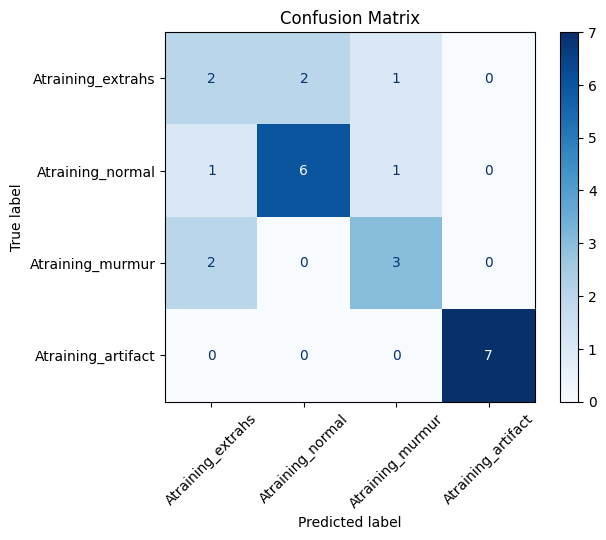

Classification Report:
                     precision    recall  f1-score   support

 Atraining_extrahs       0.40      0.40      0.40         5
  Atraining_normal       0.75      0.75      0.75         8
  Atraining_murmur       0.60      0.60      0.60         5
Atraining_artifact       1.00      1.00      1.00         7

          accuracy                           0.72        25
         macro avg       0.69      0.69      0.69        25
      weighted avg       0.72      0.72      0.72        25



In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d',xticks_rotation=45)
plt.title('Confusion Matrix')
plt.savefig("Heartbeat classification using CNN")
plt.show()
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
# plt.title('Confusion Matrix')
# plt.show()
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)


In [ ]:


# Define the path to the additional testing data directory
additional_test_data_dir = '/content/drive/MyDrive/class b folder'

# Dynamically determine class labels for additional testing based on subfolder names
additional_test_class_labels = os.listdir(additional_test_data_dir)
additional_test_class_labels

['Atraining_murmur',
 'Atraining_normal',
 'Btraining_extrasystole',
 'Bunlabelledtest',
 '.ipynb_checkpoints']

Epoch 1/20
3/3 [==============================] - 1s 92ms/step - loss: 4.8552 - accuracy: 0.5056 - val_loss: 7.0904 - val_accuracy: 0.6000
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 3.8905 - accuracy: 0.5730 - val_loss: 4.3681 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 0s 27ms/step - loss: 1.6061 - accuracy: 0.6067 - val_loss: 2.4737 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 0s 24ms/step - loss: 1.1352 - accuracy: 0.7079 - val_loss: 1.1109 - val_accuracy: 0.7000
Epoch 5/20
3/3 [==============================] - 0s 23ms/step - loss: 0.5513 - accuracy: 0.8315 - val_loss: 1.7526 - val_accuracy: 0.7000
Epoch 6/20
3/3 [==============================] - 0s 23ms/step - loss: 0.8507 - accuracy: 0.8090 - val_loss: 1.6851 - val_accuracy: 0.7000
Epoch 7/20
3/3 [==============================] - 0s 23ms/step - loss: 0.6092 - accuracy: 0.8652 - val_loss: 1.3165 - val_accuracy: 0.8000
Epoch 8/20
3/3 [===========

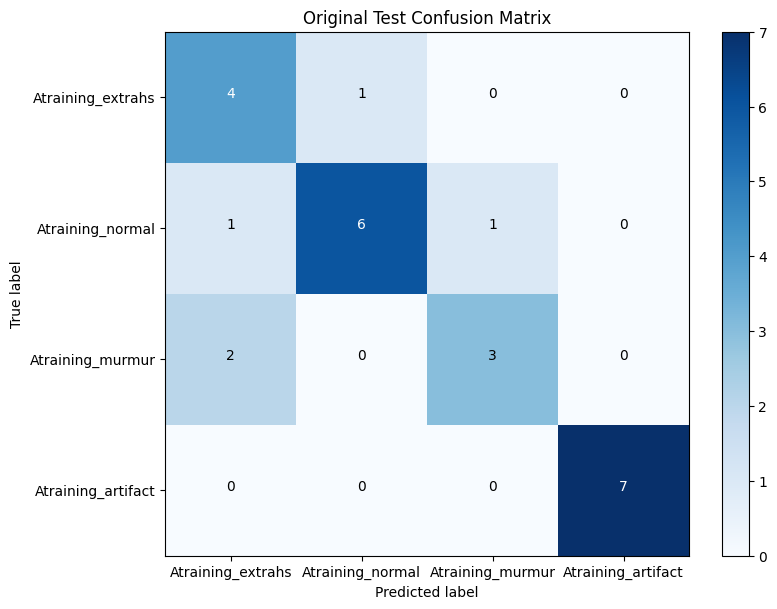

13/13 [==============================] - 0s 3ms/step
Test accuracy: 0.800000011920929
Additional Test class b Confusion Matrix:
[[ 89  35 169  27]
 [ 27  11  26  31]
 [  0   0   0   0]
 [  0   0   0   0]]
Additional Test class b Classification Report:
                   precision    recall  f1-score   support

Atraining_normal       0.77      0.28      0.41       320
Atraining_murmur       0.24      0.12      0.16        95

       micro avg       0.62      0.24      0.35       415
       macro avg       0.50      0.20      0.28       415
    weighted avg       0.65      0.24      0.35       415



In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import itertools  # Import itertools

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Define the path to the additional testing data directory
additional_test_data_dir = '/content/drive/MyDrive/class b folder'

# Define the specific class labels you want to consider for additional testing
additional_test_specific_class_labels = ['Atraining_normal', 'Atraining_murmur']

# Filter subfolders based on the specific class labels
additional_test_class_labels = [label for label in os.listdir(additional_test_data_dir) if label in additional_test_specific_class_labels]

# Create a list to store spectrogram data and corresponding labels for additional testing
additional_test_data = []
additional_test_labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder) for additional testing
for label in additional_test_class_labels:
    label_dir = os.path.join(additional_test_data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        additional_test_data.append(spectrogram)
        additional_test_labels.append(additional_test_specific_class_labels.index(label))

# Convert additional testing data and labels to NumPy arrays
additional_test_data = np.array(additional_test_data)
additional_test_labels = np.array(additional_test_labels)

# Normalize the additional testing data
additional_test_data = (additional_test_data - additional_test_data.mean()) / additional_test_data.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=(desired_shape[0], desired_shape[1], 1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(desired_shape[0], desired_shape[1], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model on the original testing data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Original Test accuracy:", test_acc)

# Predict class labels for the original test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix for original testing
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Custom Confusion Matrix Display Function
def plot_confusion_matrix(confusion_matrix, class_labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Original Test Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)  # Set x-axis ticks to class_labels
    plt.yticks(tick_marks, class_labels)

    thresh = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Use the custom function to display the confusion matrix
plot_confusion_matrix(confusion_mtx, class_labels)
plt.show()

# Calculate F1 score and other metrics for additional testing
unique_labels = np.unique(additional_test_labels)
additional_test_pred_probs = model.predict(additional_test_data)
additional_test_pred_classes = np.argmax(additional_test_pred_probs, axis=1)
additional_test_confusion_mtx = confusion_matrix(additional_test_labels, additional_test_pred_classes)
additional_test_classification_rep = classification_report(additional_test_labels, additional_test_pred_classes, labels=unique_labels, target_names=additional_test_specific_class_labels)
print("Test accuracy:", test_acc)
print("Additional Test class b Confusion Matrix:")
print(additional_test_confusion_mtx)
print("Additional Test class b Classification Report:\n", additional_test_classification_rep)


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the original dataset
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model on the original test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Original Test accuracy:", test_acc)

# Determine the minimum number of samples across all classes
min_samples = min(class_sample_counts.values())

# Create lists to store balanced data and labels
balanced_data = []
balanced_labels = []

# Randomly select the minimum number of samples from each class
for label in class_labels:
    label_idx = class_labels.index(label)
    label_data = X_train[y_train == label_idx]
    label_data = shuffle(label_data, random_state=42)[:min_samples]
    label_labels = [label_idx] * min_samples

    balanced_data.extend(label_data)
    balanced_labels.extend(label_labels)

# Convert balanced data and labels to NumPy arrays
balanced_data = np.array(balanced_data)
balanced_labels = np.array(balanced_labels)

# Shuffle the balanced data and labels
balanced_data, balanced_labels = shuffle(balanced_data, balanced_labels, random_state=42)

# Normalize the balanced data
balanced_data = (balanced_data - balanced_data.mean()) / balanced_data.std()

# Train the model on the balanced dataset
model.fit(balanced_data, balanced_labels, epochs=20, validation_split=0.1)

# Evaluate the model on the balanced dataset
y_pred_balanced_probabilities = model.predict(balanced_data)
y_pred_balanced_classes = np.argmax(y_pred_balanced_probabilities, axis=1)
f1 = f1_score(balanced_labels, y_pred_balanced_classes, average='macro')
accuracy = accuracy_score(balanced_labels, y_pred_balanced_classes)

print(f"F1 Score on Balanced Dataset: {f1}")
print(f"Accuracy on Balanced Dataset: {accuracy}")


Epoch 1/20
3/3 [==============================] - 1s 98ms/step - loss: 5.8176 - accuracy: 0.2921 - val_loss: 6.1791 - val_accuracy: 0.6000
Epoch 2/20
3/3 [==============================] - 0s 23ms/step - loss: 7.8009 - accuracy: 0.5506 - val_loss: 3.3977 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 0s 22ms/step - loss: 4.9149 - accuracy: 0.5506 - val_loss: 3.1108 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 0s 23ms/step - loss: 2.1443 - accuracy: 0.5843 - val_loss: 2.0038 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 0s 23ms/step - loss: 1.0566 - accuracy: 0.6067 - val_loss: 1.5007 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 0.8989 - accuracy: 0.5730 - val_loss: 0.7286 - val_accuracy: 0.7000
Epoch 7/20
3/3 [==============================] - 0s 24ms/step - loss: 0.7227 - accuracy: 0.7079 - val_loss: 0.6331 - val_accuracy: 0.7000
Epoch 8/20
3/3 [===========

76
Epoch 1/20
2/2 [==============================] - 1s 265ms/step - loss: 6.9864 - accuracy: 0.2407 - val_loss: 17.1198 - val_accuracy: 0.0000e+00
Epoch 2/20
2/2 [==============================] - 0s 65ms/step - loss: 6.4029 - accuracy: 0.4074 - val_loss: 7.9536 - val_accuracy: 0.0000e+00
Epoch 3/20
2/2 [==============================] - 0s 65ms/step - loss: 4.5469 - accuracy: 0.4074 - val_loss: 6.0896 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 0s 66ms/step - loss: 3.1306 - accuracy: 0.6111 - val_loss: 4.9754 - val_accuracy: 0.6667
Epoch 5/20
2/2 [==============================] - 0s 69ms/step - loss: 2.2474 - accuracy: 0.6296 - val_loss: 4.0424 - val_accuracy: 0.0000e+00
Epoch 6/20
2/2 [==============================] - 0s 46ms/step - loss: 1.1664 - accuracy: 0.6481 - val_loss: 3.3170 - val_accuracy: 0.0000e+00
Epoch 7/20
2/2 [==============================] - 0s 63ms/step - loss: 0.9885 - accuracy: 0.5741 - val_loss: 0.5723 - val_accuracy: 0.6667
Epoch 

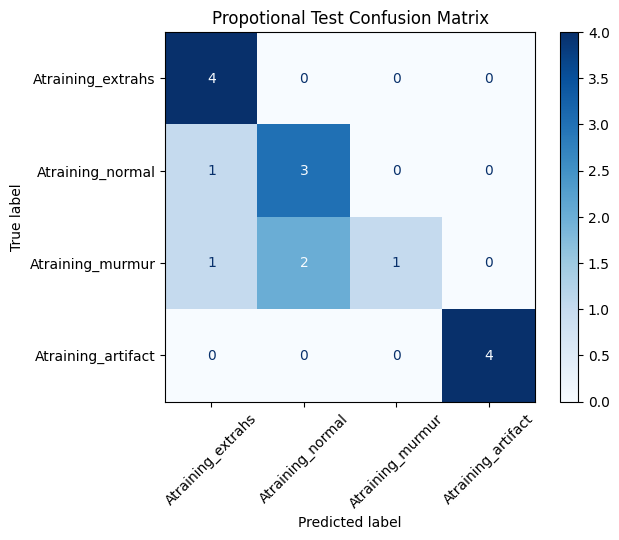

Classification Report:
                     precision    recall  f1-score   support

 Atraining_extrahs       0.67      1.00      0.80         4
  Atraining_normal       0.60      0.75      0.67         4
  Atraining_murmur       1.00      0.25      0.40         4
Atraining_artifact       1.00      1.00      1.00         4

          accuracy                           0.75        16
         macro avg       0.82      0.75      0.72        16
      weighted avg       0.82      0.75      0.72        16

Samples from each classes 19
Atraining_extrahs 19
Atraining_normal 31
Atraining_murmur 34
Atraining_artifact 40


In [ ]:
# try propotions
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Minimum number of samples in any class
min_samples = min(len(os.listdir(os.path.join(data_dir, label))) for label in class_labels)

# Iterate through each class label (subfolder) and randomly select min_samples
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    samples = np.random.choice(os.listdir(label_dir), min_samples, replace=False)

    for audio_file in samples:
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
print(len(data))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42,stratify=labels)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model

model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model on the original testing data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("New propotional Test accuracy:", test_acc)

# Predict class labels for the original test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix for original testing
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object and display the confusion matrix for original testing
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)
plt.title('Propotional Test Confusion Matrix')
plt.show()

# Generate classification report
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)
print("Samples from each classes",min_samples)
for label in class_labels:
  print(label,len(os.listdir(os.path.join(data_dir, label))))



In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Minimum number of samples in any class
min_samples = min(len(os.listdir(os.path.join(data_dir, label))) for label in class_labels)
label_samples = {"Atraining_extrahs": 19,
"Atraining_normal": 22,
"Atraining_murmur": 22,
"Atraining_artifact":22 }


# Number of runs
num_runs = 5

# Create empty lists to store results
f1_scores_list = []
precision_list = []
recall_list = []
overall_f1_list = []

for run in range(num_runs):
    # Create lists to store data for each run
    data_run = []
    labels_run = []

    # Iterate through each class label (subfolder) and randomly select min_samples with stratified sampling
    for label in class_labels:
        label_dir = os.path.join(data_dir, label)
        samples = np.random.choice(os.listdir(label_dir), label_samples[label], replace=False)

        for audio_file in samples:
            audio_path = os.path.join(label_dir, audio_file)
            spectrogram = extract_features(audio_path, desired_shape)
            data_run.append(spectrogram)
            labels_run.append(class_labels.index(label))

    # Convert data and labels to NumPy arrays
    data_run = np.array(data_run)
    labels_run = np.array(labels_run)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_run, labels_run, test_size=0.2, random_state=42, stratify=labels_run)

    # Normalize the data
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    # Build a simple CNN model
    model = models.Sequential([
        layers.Input(shape=X_train[0].shape),
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_labels), activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=20, validation_split=0.1)

    # Predict class labels for the original test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate classification report
    classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels, output_dict=True)

    # Extract F1 scores, precision, and recall for each label
    f1_scores = [classification_rep[label]['f1-score'] for label in class_labels]
    precision = [classification_rep[label]['precision'] for label in class_labels]
    recall = [classification_rep[label]['recall'] for label in class_labels]

    # Calculate overall F1 score
    overall_f1 = np.mean(f1_scores)

    # Append results for this run to the respective lists
    f1_scores_list.append(f1_scores)
    precision_list.append(precision)
    recall_list.append(recall)
    overall_f1_list.append(overall_f1)

# Create DataFrames for F1 scores, precision, and recall for each label
f1_scores_df = pd.DataFrame(f1_scores_list, columns=[f'f1_{label}' for label in class_labels])
precision_df = pd.DataFrame(precision_list, columns=[f'precision_{label}' for label in class_labels])
recall_df = pd.DataFrame(recall_list, columns=[f'recall_{label}' for label in class_labels])
overall_f1_df = pd.DataFrame(overall_f1_list, columns=['Overall_F1_Score'])

# Concatenate all DataFrames into a single DataFrame
results_df = pd.concat([f1_scores_df, precision_df, recall_df, overall_f1_df], axis=1)

# Display the results DataFrame
print("Results:\n", results_df)
print(len(data_run))


Epoch 1/20
2/2 [==============================] - 2s 536ms/step - loss: 4.8268 - accuracy: 0.2787 - val_loss: 5.9631 - val_accuracy: 0.5714
Epoch 2/20
2/2 [==============================] - 0s 81ms/step - loss: 7.7733 - accuracy: 0.5574 - val_loss: 6.4804 - val_accuracy: 0.4286
Epoch 3/20
2/2 [==============================] - 0s 66ms/step - loss: 6.1990 - accuracy: 0.4590 - val_loss: 3.2385 - val_accuracy: 0.4286
Epoch 4/20
2/2 [==============================] - 0s 72ms/step - loss: 3.6910 - accuracy: 0.5738 - val_loss: 3.1804 - val_accuracy: 0.2857
Epoch 5/20
2/2 [==============================] - 0s 71ms/step - loss: 2.0924 - accuracy: 0.6230 - val_loss: 2.1838 - val_accuracy: 0.5714
Epoch 6/20
2/2 [==============================] - 0s 66ms/step - loss: 1.1483 - accuracy: 0.5902 - val_loss: 1.1454 - val_accuracy: 0.5714
Epoch 7/20
2/2 [==============================] - 0s 64ms/step - loss: 0.9662 - accuracy: 0.7377 - val_loss: 0.4318 - val_accuracy: 0.8571
Epoch 8/20
2/2 [==========

In [ ]:
for label in class_labels:
  print(len(os.listdir(os.path.join(data_dir,label))),label)


19 Atraining_extrahs
31 Atraining_normal
34 Atraining_murmur
40 Atraining_artifact


In [ ]:

results_df.to_csv("22_data_set.csv",index=False)

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
# data_dir = 'your_dataset_directory'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d',xticks_rotation=45)
plt.title('Confusion Matrix')
plt.savefig("Heartbeat classification using CNN")
plt.show()
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
# plt.title('Confusion Matrix')
# plt.show()
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)


NameError: name 'data_dir' is not defined

In [ ]:
!pip install pydoe2

  Preparing metadata (setup.py) ... done
  Created wheel for pydoe2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25521 sha256=ec2506c0032e71d3959d53462bdf29f02b6c9bf805ed16de07a1a790c437b4a7
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built pydoe2


In [ ]:
# Simplified Taguchi L16 Orthogonal Array for 4 factors with 4 levels
experiments = [
    [0.1, 0.1, 0.1, 0.1],  # Experiment 1
    [0.1, 0.2, 0.3, 0.4],  # Experiment 2
    [0.1, 0.3, 0.4, 0.2],  # Experiment 3
    [0.1, 0.4, 0.2, 0.3],  # Experiment 4
    [0.2, 0.1, 0.4, 0.3],  # Experiment 5
    [0.2, 0.2, 0.1, 0.4],  # Experiment 6
    [0.2, 0.3, 0.2, 0.1],  # Experiment 7
    [0.2, 0.4, 0.3, 0.2],  # Experiment 8
    [0.3, 0.1, 0.2, 0.4],  # Experiment 9
    [0.3, 0.2, 0.4, 0.1],  # Experiment 10
    [0.3, 0.3, 0.1, 0.2],  # Experiment 11
    [0.3, 0.4, 0.3, 0.1],  # Experiment 12
    [0.4, 0.1, 0.3, 0.2],  # Experiment 13
    [0.4, 0.2, 0.2, 0.3],  # Experiment 14
    [0.4, 0.3, 0.1, 0.4],  # Experiment 15
    [0.4, 0.4, 0.4, 0.4],  # Experiment 16
]

# Print the simplified Taguchi design experiments
print("Simplified Taguchi L16 Design Experiments:")
for exp in experiments:
    print(exp)


Simplified Taguchi L16 Design Experiments:
[0.1, 0.1, 0.1, 0.1]
[0.1, 0.2, 0.3, 0.4]
[0.1, 0.3, 0.4, 0.2]
[0.1, 0.4, 0.2, 0.3]
[0.2, 0.1, 0.4, 0.3]
[0.2, 0.2, 0.1, 0.4]
[0.2, 0.3, 0.2, 0.1]
[0.2, 0.4, 0.3, 0.2]
[0.3, 0.1, 0.2, 0.4]
[0.3, 0.2, 0.4, 0.1]
[0.3, 0.3, 0.1, 0.2]
[0.3, 0.4, 0.3, 0.1]
[0.4, 0.1, 0.3, 0.2]
[0.4, 0.2, 0.2, 0.3]
[0.4, 0.3, 0.1, 0.4]
[0.4, 0.4, 0.4, 0.4]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
# from pyDOE import doe_taguchi


In [ ]:
!pwd

/content


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import random
import os
import librosa
import cv2
from sklearn.model_selection import train_test_split

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/drive/MyDrive/class_folder'  # Replace with the path to your dataset

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Load data
data = []
labels = []
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, (128, 128))  # Replace with your desired shape
        data.append(spectrogram)
        labels.append(class_labels.index(label))

data = np.array(data)
labels = np.array(labels)

# Simplified Taguchi L16 Orthogonal Array for 4 factors with 4 levels

def custom_train_test_split(data, labels, test_proportions, class_labels):
    # Your custom train-test split logic
    pass

def create_model(input_shape, num_classes):
    model = models.Sequential([
        # Your model architecture
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

results = []
experiments = [
      [0.1, 0.1, 0.1, 0.1],  # Experiment 1
    [0.1, 0.2, 0.3, 0.4],  # Experiment 2
    [0.1, 0.3, 0.4, 0.2],  # Experiment 3
    [0.1, 0.4, 0.2, 0.3],  # Experiment 4
    [0.2, 0.1, 0.4, 0.3],  # Experiment 5
    [0.2, 0.2, 0.1, 0.4],  # Experiment 6
    [0.2, 0.3, 0.2, 0.1],  # Experiment 7
    [0.2, 0.4, 0.3, 0.2],  # Experiment 8
    [0.3, 0.1, 0.2, 0.4],  # Experiment 9
    [0.3, 0.2, 0.4, 0.1],  # Experiment 10
    [0.3, 0.3, 0.1, 0.2],  # Experiment 11
    [0.3, 0.4, 0.3, 0.1],  # Experiment 12
    [0.4, 0.1, 0.3, 0.2],  # Experiment 13
    [0.4, 0.2, 0.2, 0.3],  # Experiment 14
    [0.4, 0.3, 0.1, 0.4],  # Experiment 15
     [0.4, 0.4, 0.4, 0.4],  # Experiment 16
 ]

# Run experiments
for exp in experiments:
    X_train, X_test, y_train, y_test = custom_train_test_split(data, labels, exp, class_labels)
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    model = create_model(X_train[0].shape, len(class_labels))
    model.fit(X_train, y_train, epochs=20, validation_split=0.1)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels, output_dict=True)

    results.append({
        "experiment": exp,
        "classification_report": classification_rep
    })

# Print the results in a table format
for result in results:
    print(f"Experiment {result['experiment']}:")
    for class_name, class_metrics in result["classification_report"].items():
        if class_name in class_labels:
            print(f"Class: {class_name}, Precision: {class_metrics['precision']}, Recall: {class_metrics['recall']}, F1-Score: {class_metrics['f1-score']}")
    print("\n")


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import librosa
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import random

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Define your dataset directory and class labels
data_dir = '/content/drive/MyDrive/class_folder'  # Replace with your dataset directory
class_labels = ['Atraining_artifact','Atraining_extrahs','Atraining_murmur','Atraining_normal']  # Replace with your class labels

# Load data
data = []
labels = []
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, (128, 128))  # Replace with your desired shape
        data.append(spectrogram)
        labels.append(class_labels.index(label))

data = np.array(data)
labels = np.array(labels)

# Simplified Taguchi L16 Orthogonal Array for 4 factors with 4 levels
experiments = [
    [0.1, 0.1, 0.1, 0.1],  # Experiment 1
    [0.1, 0.2, 0.3, 0.4],  # Experiment 2
    [0.1, 0.3, 0.4, 0.2],  # Experiment 3
    [0.1, 0.4, 0.2, 0.3],  # Experiment 4
    [0.2, 0.1, 0.4, 0.3],  # Experiment 5
    [0.2, 0.2, 0.1, 0.4],  # Experiment 6
    [0.2, 0.3, 0.2, 0.1],  # Experiment 7
    [0.2, 0.4, 0.3, 0.2],  # Experiment 8
    [0.3, 0.1, 0.2, 0.4],  # Experiment 9
    [0.3, 0.2, 0.4, 0.1],  # Experiment 10
    [0.3, 0.3, 0.1, 0.2],  # Experiment 11
    [0.3, 0.4, 0.3, 0.1],  # Experiment 12
    [0.4, 0.1, 0.3, 0.2],  # Experiment 13
    [0.4, 0.2, 0.2, 0.3],  # Experiment 14
    [0.4, 0.3, 0.1, 0.4],  # Experiment 15
     [0.4, 0.4, 0.4, 0.4],  # Experiment 16
 ]


# Custom Train-Test Split
def custom_train_test_split(data, labels, test_proportions, num_classes):
    X_train, X_test, y_train, y_test = [], [], [], []
    class_data = {i: [] for i in range(num_classes)}  # Use numeric indices for classes

    for d, label in zip(data, labels):
        class_data[label].append(d)

    for class_idx, proportion in enumerate(test_proportions):
        n_test_samples = int(proportion * len(class_data[class_idx]))
        n_train_samples = len(class_data[class_idx]) - n_test_samples

        np.random.shuffle(class_data[class_idx])
        X_test += class_data[class_idx][:n_test_samples]
        y_test += [class_idx] * n_test_samples
        X_train += class_data[class_idx][n_test_samples:]
        y_train += [class_idx] * n_train_samples

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


# CNN Model
def create_model(input_shape, num_classes):
    # model = models.Sequential([
    #     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Conv2D(64, (3, 3), activation='relu'),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Conv2D(128, (3, 3), activation='relu'),
    #     layers.GlobalAveragePooling2D(),
    #     layers.Dense(64, activation='relu'),
    #     layers.Dense(num_classes, activation='softmax')
    # ])
    model = models.Sequential([
      layers.Input(shape=X_train[0].shape),
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(len(class_labels), activation='softmax')
  ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize DataFrame for results
results_df = pd.DataFrame()
num_classes = len(class_labels)  # Number of classes
# Run experiments and store results
for exp in experiments:
    X_train, X_test, y_train, y_test = custom_train_test_split(data, labels, exp, num_classes)
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    model = create_model(X_train[0].shape, len(class_labels))
    model.fit(X_train, y_train, epochs=20, validation_split=0.1)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels, output_dict=True)

    for class_name in class_labels:
            if class_name in classification_rep:
                class_metrics = classification_rep[class_name]
                results_df = results_df.append({
                    "Experiment": str(exp),
                    "Class": class_name,
                    "Precision": class_metrics['precision'],
                    "Recall": class_metrics['recall'],
                    "F1-Score": class_metrics['f1-score']
                }, ignore_index=True)

# Display the results
print(results_df)


Epoch 1/20
4/4 [==============================] - 4s 325ms/step - loss: 9.3011 - accuracy: 0.4059 - val_loss: 10.8106 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 1s 253ms/step - loss: 4.6731 - accuracy: 0.5149 - val_loss: 9.9714 - val_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 1s 257ms/step - loss: 1.7091 - accuracy: 0.6139 - val_loss: 1.6322 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 1s 258ms/step - loss: 1.5212 - accuracy: 0.6238 - val_loss: 4.5294 - val_accuracy: 0.0000e+00
Epoch 5/20
4/4 [==============================] - 1s 237ms/step - loss: 1.0368 - accuracy: 0.6931 - val_loss: 6.4402 - val_accuracy: 0.0000e+00
Epoch 6/20
4/4 [==============================] - 1s 261ms/step - loss: 1.0068 - accuracy: 0.6733 - val_loss: 3.8843 - val_accuracy: 0.0000e+00
Epoch 7/20
4/4 [==============================] - 1s 256ms/step - loss: 0.5622 - accuracy: 0.8218 - val_loss: 2.0857 - val_accuracy: 0.1667
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.ap

Epoch 1/20
3/3 [==============================] - 2s 606ms/step - loss: 5.4104 - accuracy: 0.3765 - val_loss: 17.4131 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 448ms/step - loss: 3.1310 - accuracy: 0.6235 - val_loss: 3.1577 - val_accuracy: 0.1000
Epoch 3/20
3/3 [==============================] - 2s 512ms/step - loss: 1.0095 - accuracy: 0.7176 - val_loss: 1.1659 - val_accuracy: 0.4000
Epoch 4/20
3/3 [==============================] - 1s 473ms/step - loss: 0.8077 - accuracy: 0.6941 - val_loss: 2.1997 - val_accuracy: 0.2000
Epoch 5/20
3/3 [==============================] - 1s 296ms/step - loss: 0.4795 - accuracy: 0.7882 - val_loss: 3.4112 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 349ms/step - loss: 0.4164 - accuracy: 0.8471 - val_loss: 4.0222 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 311ms/step - loss: 0.3878 - accuracy: 0.8706 - val_loss: 3.0583 - val_accuracy: 0.0000e+00
Epo

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 395ms/step - loss: 12.1124 - accuracy: 0.3605 - val_loss: 5.9903 - val_accuracy: 0.4000
Epoch 2/20
3/3 [==============================] - 1s 352ms/step - loss: 4.3353 - accuracy: 0.5349 - val_loss: 1.9784 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 313ms/step - loss: 2.6919 - accuracy: 0.4419 - val_loss: 5.7808 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 2s 497ms/step - loss: 1.6524 - accuracy: 0.6744 - val_loss: 7.2324 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 500ms/step - loss: 1.6550 - accuracy: 0.6163 - val_loss: 2.3983 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 1s 459ms/step - loss: 0.7746 - accuracy: 0.7326 - val_loss: 0.9236 - val_accuracy: 0.7000
Epoch 7/20
3/3 [==============================] - 1s 281ms/step - loss: 0.4776 - accuracy: 0.7791 - val_loss: 4.0481 - val_accuracy: 0.0000e+00
Epoch 8

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 389ms/step - loss: 7.3252 - accuracy: 0.4318 - val_loss: 9.5380 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 339ms/step - loss: 2.5515 - accuracy: 0.5455 - val_loss: 0.4779 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 1s 323ms/step - loss: 1.1530 - accuracy: 0.6818 - val_loss: 5.5072 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 1s 337ms/step - loss: 1.3235 - accuracy: 0.7614 - val_loss: 7.3409 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 291ms/step - loss: 1.3444 - accuracy: 0.7273 - val_loss: 6.8392 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 339ms/step - loss: 0.9205 - accuracy: 0.8182 - val_loss: 4.2202 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 1s 336ms/step - loss: 0.7210 - accuracy: 0.7841 - val_loss: 2.4696 - val_accuracy: 0.6000
Epoch 8/

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 436ms/step - loss: 9.1203 - accuracy: 0.5181 - val_loss: 10.8520 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 278ms/step - loss: 4.1988 - accuracy: 0.3494 - val_loss: 1.2951 - val_accuracy: 0.6000
Epoch 3/20
3/3 [==============================] - 1s 259ms/step - loss: 1.6153 - accuracy: 0.6627 - val_loss: 7.8480 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 290ms/step - loss: 1.5816 - accuracy: 0.6265 - val_loss: 6.4253 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 303ms/step - loss: 0.7295 - accuracy: 0.7349 - val_loss: 2.3223 - val_accuracy: 0.2000
Epoch 6/20
3/3 [==============================] - 1s 278ms/step - loss: 0.7559 - accuracy: 0.8313 - val_loss: 1.6572 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 1s 278ms/step - loss: 0.5372 - accuracy: 0.8313 - val_loss: 3.5229 - val_accuracy: 0.2000
Epoch 8

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 3s 471ms/step - loss: 5.4029 - accuracy: 0.4773 - val_loss: 13.2530 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 305ms/step - loss: 3.0853 - accuracy: 0.5795 - val_loss: 3.0898 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 375ms/step - loss: 0.8190 - accuracy: 0.7386 - val_loss: 9.0912 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 333ms/step - loss: 1.1262 - accuracy: 0.7727 - val_loss: 8.1626 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 276ms/step - loss: 0.7410 - accuracy: 0.8182 - val_loss: 2.9069 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 361ms/step - loss: 0.4853 - accuracy: 0.8523 - val_loss: 0.4393 - val_accuracy: 0.9000
Epoch 7/20
3/3 [==============================] - 1s 281ms/step - loss: 0.4118 - accuracy: 0.8636 - val_loss: 2.2455 - val_accuracy: 0.0000e+00

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 462ms/step - loss: 4.9916 - accuracy: 0.3956 - val_loss: 3.8337 - val_accuracy: 0.4545
Epoch 2/20
3/3 [==============================] - 1s 531ms/step - loss: 3.0373 - accuracy: 0.5714 - val_loss: 5.0782 - val_accuracy: 0.2727
Epoch 3/20
3/3 [==============================] - 1s 447ms/step - loss: 1.6039 - accuracy: 0.6264 - val_loss: 7.4883 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 2s 546ms/step - loss: 0.9920 - accuracy: 0.7582 - val_loss: 5.7541 - val_accuracy: 0.5455
Epoch 5/20
3/3 [==============================] - 1s 433ms/step - loss: 0.6926 - accuracy: 0.8132 - val_loss: 5.8130 - val_accuracy: 0.4545
Epoch 6/20
3/3 [==============================] - 1s 306ms/step - loss: 0.5483 - accuracy: 0.8681 - val_loss: 4.0480 - val_accuracy: 0.4545
Epoch 7/20
3/3 [==============================] - 1s 374ms/step - loss: 0.2870 - accuracy: 0.9011 - val_loss: 2.3148 - val_accuracy: 0.3636
Epoch 8/20
3/3 [

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 464ms/step - loss: 6.3273 - accuracy: 0.5422 - val_loss: 38.8344 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 345ms/step - loss: 8.4092 - accuracy: 0.6627 - val_loss: 7.3519 - val_accuracy: 0.2000
Epoch 3/20
3/3 [==============================] - 1s 346ms/step - loss: 3.2343 - accuracy: 0.3614 - val_loss: 4.4119 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 467ms/step - loss: 1.4353 - accuracy: 0.6747 - val_loss: 1.4456 - val_accuracy: 0.6000
Epoch 5/20
3/3 [==============================] - 2s 541ms/step - loss: 1.4894 - accuracy: 0.7229 - val_loss: 1.3232 - val_accuracy: 0.8000
Epoch 6/20
3/3 [==============================] - 2s 533ms/step - loss: 1.1939 - accuracy: 0.7831 - val_loss: 2.5568 - val_accuracy: 0.8000
Epoch 7/20
3/3 [==============================] - 2s 541ms/step - loss: 0.8441 - accuracy: 0.8072 - val_loss: 2.8968 - val_accuracy: 0.6000
Epoch 8/20


<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 452ms/step - loss: 4.1331 - accuracy: 0.5301 - val_loss: 32.1325 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 330ms/step - loss: 3.4737 - accuracy: 0.6145 - val_loss: 14.5819 - val_accuracy: 0.4000
Epoch 3/20
3/3 [==============================] - 1s 325ms/step - loss: 3.2671 - accuracy: 0.6145 - val_loss: 16.9460 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 299ms/step - loss: 1.9412 - accuracy: 0.7349 - val_loss: 11.5442 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 293ms/step - loss: 1.0261 - accuracy: 0.7229 - val_loss: 7.0329 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 316ms/step - loss: 0.7654 - accuracy: 0.7590 - val_loss: 2.9257 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 1s 350ms/step - loss: 0.4231 - accuracy: 0.8193 - val_loss: 6.7322 - val_accuracy: 0.0000e

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 379ms/step - loss: 6.1934 - accuracy: 0.3855 - val_loss: 13.2708 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 279ms/step - loss: 4.9214 - accuracy: 0.4096 - val_loss: 11.2621 - val_accuracy: 0.1000
Epoch 3/20
3/3 [==============================] - 1s 301ms/step - loss: 3.8375 - accuracy: 0.5663 - val_loss: 1.4297 - val_accuracy: 0.6000
Epoch 4/20
3/3 [==============================] - 1s 358ms/step - loss: 2.2358 - accuracy: 0.5663 - val_loss: 2.8697 - val_accuracy: 0.2000
Epoch 5/20
3/3 [==============================] - 1s 295ms/step - loss: 1.2436 - accuracy: 0.7229 - val_loss: 5.3775 - val_accuracy: 0.2000
Epoch 6/20
3/3 [==============================] - 1s 288ms/step - loss: 0.8793 - accuracy: 0.8193 - val_loss: 5.3930 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 1s 316ms/step - loss: 0.7957 - accuracy: 0.8313 - val_loss: 4.0912 - val_accuracy: 0.2000
Epoch 8/20
3/3

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


3/3 [==============================] - 2s 440ms/step - loss: 13.1781 - accuracy: 0.2614 - val_loss: 25.3776 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 328ms/step - loss: 8.2649 - accuracy: 0.5341 - val_loss: 9.2886 - val_accuracy: 0.1000
Epoch 3/20
3/3 [==============================] - 1s 316ms/step - loss: 3.7360 - accuracy: 0.6136 - val_loss: 2.6781 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 1s 306ms/step - loss: 1.6524 - accuracy: 0.7045 - val_loss: 2.5978 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 1s 313ms/step - loss: 1.3588 - accuracy: 0.6136 - val_loss: 1.7892 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 1s 374ms/step - loss: 0.8634 - accuracy: 0.7955 - val_loss: 2.0270 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 1s 417ms/step - loss: 0.5099 - accuracy: 0.8409 - val_loss: 3.2926 - val_accuracy: 0.0000e+00
Epoch 8/20
3/3 [=====

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 3s 595ms/step - loss: 5.3606 - accuracy: 0.4878 - val_loss: 0.7743 - val_accuracy: 0.8000
Epoch 2/20
3/3 [==============================] - 1s 474ms/step - loss: 3.6035 - accuracy: 0.4756 - val_loss: 12.8802 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 465ms/step - loss: 3.1273 - accuracy: 0.6220 - val_loss: 2.6680 - val_accuracy: 0.2000
Epoch 4/20
3/3 [==============================] - 1s 335ms/step - loss: 0.8625 - accuracy: 0.8049 - val_loss: 1.3298 - val_accuracy: 0.7000
Epoch 5/20
3/3 [==============================] - 1s 322ms/step - loss: 1.0181 - accuracy: 0.7317 - val_loss: 1.3587 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 1s 270ms/step - loss: 0.4765 - accuracy: 0.8415 - val_loss: 3.1631 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 289ms/step - loss: 0.4407 - accuracy: 0.8171 - val_loss: 2.8056 - val_accuracy: 0.1000
Epoch 8/20


<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


3/3 [==============================] - 2s 362ms/step - loss: 7.4181 - accuracy: 0.4444 - val_loss: 6.9398 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 257ms/step - loss: 7.8062 - accuracy: 0.3210 - val_loss: 8.0023 - val_accuracy: 0.2000
Epoch 3/20
3/3 [==============================] - 1s 245ms/step - loss: 2.4308 - accuracy: 0.6543 - val_loss: 15.9233 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 273ms/step - loss: 3.3612 - accuracy: 0.6173 - val_loss: 9.8033 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 1s 251ms/step - loss: 1.6612 - accuracy: 0.7407 - val_loss: 5.0171 - val_accuracy: 0.7000
Epoch 6/20
3/3 [==============================] - 1s 269ms/step - loss: 0.7053 - accuracy: 0.8025 - val_loss: 2.6755 - val_accuracy: 0.3000
Epoch 7/20
3/3 [==============================] - 1s 264ms/step - loss: 0.9335 - accuracy: 0.6914 - val_loss: 3.0550 - val_accuracy: 0.0000e+00
Epoch 8/20
3/3 [==

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.ap

Epoch 1/20
3/3 [==============================] - 2s 460ms/step - loss: 5.0317 - accuracy: 0.3333 - val_loss: 5.3003 - val_accuracy: 0.2222
Epoch 2/20
3/3 [==============================] - 1s 422ms/step - loss: 2.6886 - accuracy: 0.3827 - val_loss: 5.3049 - val_accuracy: 0.2222
Epoch 3/20
3/3 [==============================] - 1s 389ms/step - loss: 1.8526 - accuracy: 0.6543 - val_loss: 7.6162 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 425ms/step - loss: 1.4904 - accuracy: 0.7284 - val_loss: 2.9074 - val_accuracy: 0.3333
Epoch 5/20
3/3 [==============================] - 1s 391ms/step - loss: 0.6770 - accuracy: 0.7901 - val_loss: 3.1620 - val_accuracy: 0.1111
Epoch 6/20
3/3 [==============================] - 1s 247ms/step - loss: 0.6326 - accuracy: 0.7284 - val_loss: 3.6934 - val_accuracy: 0.1111
Epoch 7/20
3/3 [==============================] - 1s 248ms/step - loss: 0.4572 - accuracy: 0.8272 - val_loss: 2.3581 - val_accuracy: 0.2222
Epoch 8/20
3/3 [

<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/20
3/3 [==============================] - 2s 413ms/step - loss: 5.2550 - accuracy: 0.3418 - val_loss: 8.0872 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 254ms/step - loss: 3.0754 - accuracy: 0.3797 - val_loss: 4.2626 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 246ms/step - loss: 2.5585 - accuracy: 0.6456 - val_loss: 3.6269 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 266ms/step - loss: 2.4407 - accuracy: 0.5949 - val_loss: 2.5872 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 243ms/step - loss: 1.6449 - accuracy: 0.6203 - val_loss: 4.2562 - val_accuracy: 0.3333
Epoch 6/20
3/3 [==============================] - 1s 258ms/step - loss: 1.0368 - accuracy: 0.7342 - val_loss: 4.7963 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 301ms/step - loss: 0.7346 - accuracy: 0.7342 - val_loss: 3.5285 - val_accuracy: 0.0000e

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.ap

Epoch 1/20
3/3 [==============================] - 2s 339ms/step - loss: 7.1155 - accuracy: 0.4412 - val_loss: 14.3219 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 313ms/step - loss: 4.3695 - accuracy: 0.5735 - val_loss: 2.3557 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 222ms/step - loss: 1.7074 - accuracy: 0.6324 - val_loss: 3.2486 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 305ms/step - loss: 0.8735 - accuracy: 0.7353 - val_loss: 3.0280 - val_accuracy: 0.1250
Epoch 5/20
3/3 [==============================] - 1s 363ms/step - loss: 0.5828 - accuracy: 0.7794 - val_loss: 1.7899 - val_accuracy: 0.3750
Epoch 6/20
3/3 [==============================] - 1s 358ms/step - loss: 0.4680 - accuracy: 0.8529 - val_loss: 1.3008 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 1s 352ms/step - loss: 0.5715 - accuracy: 0.7941 - val_loss: 1.2109 - val_accuracy: 0.5000
Epoch 8/20


<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-25-96f56385358d>:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [ ]:
for exp in experiments:
    X_train, X_test, y_train, y_test = custom_train_test_split(data, labels, exp, class_labels)
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    model = create_model(X_train[0].shape, len(class_labels))
    model.fit(X_train, y_train, epochs=10, validation_split=0.1)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels, output_dict=True)

    # Add experiment results to DataFrame
    row = [str(exp)]
    for class_name in class_labels:
        class_metrics = classification_rep[class_name]
        row.extend([class_metrics['precision'], class_metrics['recall'], class_metrics['f1-score']])
    results_df.loc[len(results_df)] = row

# Display the final DataFrame
print(results_df.head())

# Optionally, save the final DataFrame to a new CSV file
results_df.to_csv('final_result_df.csv', index=False)

,Experiment,Atraining_artifact Precision,Atraining_artifact Recall,Atraining_artifact F1-Score,Atraining_extrahs Precision,Atraining_extrahs Recall,Atraining_extrahs F1-Score,Atraining_murmur Precision,Atraining_murmur Recall,Atraining_murmur F1-Score,Atraining_normal Precision,Atraining_normal Recall,Atraining_normal F1-Score


In [ ]:
import pandas as pd

# Load the CSV file
# results_df = pd.read_csv('/mnt/data/result_df.csv')

# Extract unique class names from a specific experiment
# Assuming that the experiment identifier column is named 'Experiment'
# and the class name column is named 'Class'
experiment_id = results_df['Experiment'].iloc[0]  # Taking the first experiment as an example
unique_classes = results_df[results_df['Experiment'] == experiment_id]['Class'].unique()

# Create DataFrame columns for precision, recall, and F1 score for each class
columns = ['Experiment'] + [f'{cls} {metric}' for cls in unique_classes for metric in ['Precision', 'Recall', 'F1-Score']]
final_results_df = pd.DataFrame(columns=columns)

# Now populate this DataFrame with the results from your experiments
# Assuming 'results' is a list of dictionaries with experiment results
for result in results:
    row = [result['experiment']]
    for cls in unique_classes:
        if cls in result['classification_report']:
            class_metrics = result['classification_report'][cls]
            row.extend([class_metrics['precision'], class_metrics['recall'], class_metrics['f1-score']])
        else:
            # Append NaN or 0 if class metrics are not available
            row.extend([np.nan, np.nan, np.nan])
    final_results_df.loc[len(final_results_df)] = row

# Display the final DataFrame
print(final_results_df.head())

# Optionally, save the final DataFrame to a new CSV file
final_results_df.to_csv('final_result_df.csv', index=False)

NameError: name 'results' is not defined

In [ ]:
len(os.listdir('/content/drive/MyDrive/class_folder/Atraining_extrahs'))
int(0.1*19)

1

Epoch 1/20
4/4 [==============================] - 2s 309ms/step - loss: 5.7118 - accuracy: 0.3762 - val_loss: 2.7170 - val_accuracy: 0.0833
Epoch 2/20
4/4 [==============================] - 1s 254ms/step - loss: 2.9655 - accuracy: 0.5941 - val_loss: 11.5376 - val_accuracy: 0.0000e+00
Epoch 3/20
4/4 [==============================] - 1s 266ms/step - loss: 1.7829 - accuracy: 0.6931 - val_loss: 8.5545 - val_accuracy: 0.5833
Epoch 4/20
4/4 [==============================] - 1s 254ms/step - loss: 1.1378 - accuracy: 0.7228 - val_loss: 4.1915 - val_accuracy: 0.5833
Epoch 5/20
4/4 [==============================] - 1s 258ms/step - loss: 0.4590 - accuracy: 0.8713 - val_loss: 1.8166 - val_accuracy: 0.0833
Epoch 6/20
4/4 [==============================] - 1s 252ms/step - loss: 0.5073 - accuracy: 0.8317 - val_loss: 4.1327 - val_accuracy: 0.0000e+00
Epoch 7/20
4/4 [==============================] - 1s 264ms/step - loss: 0.4263 - accuracy: 0.8119 - val_loss: 2.8598 - val_accuracy: 0.3333
Epoch 8/20


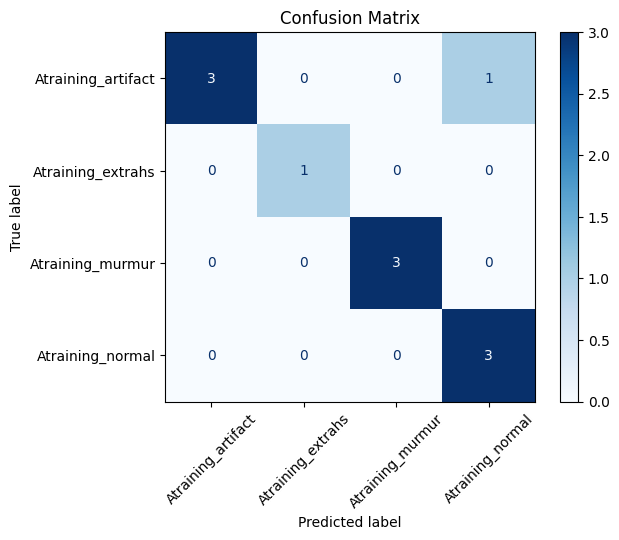

Epoch 1/20
3/3 [==============================] - 2s 363ms/step - loss: 6.5881 - accuracy: 0.4000 - val_loss: 10.6627 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 460ms/step - loss: 3.1746 - accuracy: 0.5412 - val_loss: 3.6506 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 464ms/step - loss: 1.6954 - accuracy: 0.5882 - val_loss: 1.9764 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 2s 500ms/step - loss: 0.7392 - accuracy: 0.7059 - val_loss: 2.9731 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 438ms/step - loss: 0.5142 - accuracy: 0.8471 - val_loss: 0.9175 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 1s 291ms/step - loss: 0.5199 - accuracy: 0.8353 - val_loss: 1.1571 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 1s 288ms/step - loss: 0.4747 - accuracy: 0.8706 - val_loss: 2.3779 - val_accuracy: 0.0000e+00
Epo

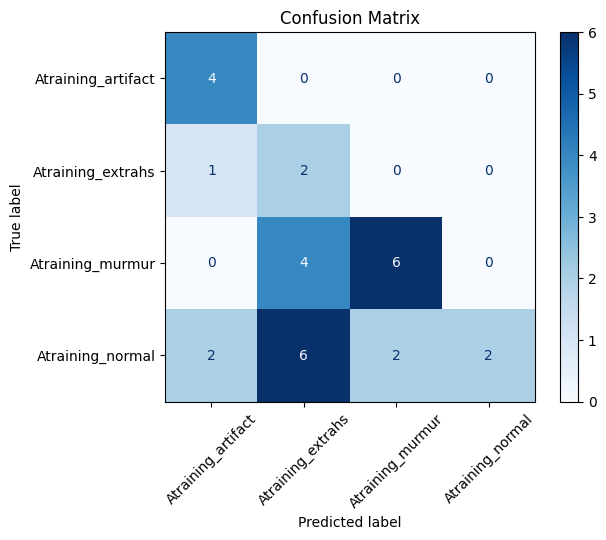

Epoch 1/20
3/3 [==============================] - 3s 593ms/step - loss: 6.7295 - accuracy: 0.4419 - val_loss: 2.6404 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 1s 368ms/step - loss: 5.1872 - accuracy: 0.5000 - val_loss: 12.5505 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 281ms/step - loss: 3.0723 - accuracy: 0.5581 - val_loss: 11.7389 - val_accuracy: 0.2000
Epoch 4/20
3/3 [==============================] - 1s 274ms/step - loss: 3.4118 - accuracy: 0.6279 - val_loss: 3.4102 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 1s 291ms/step - loss: 1.7444 - accuracy: 0.7674 - val_loss: 7.8352 - val_accuracy: 0.1000
Epoch 6/20
3/3 [==============================] - 1s 270ms/step - loss: 2.1851 - accuracy: 0.6977 - val_loss: 9.0197 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 296ms/step - loss: 1.1368 - accuracy: 0.7674 - val_loss: 4.7143 - val_accuracy: 0.0000e+00
Epoch 

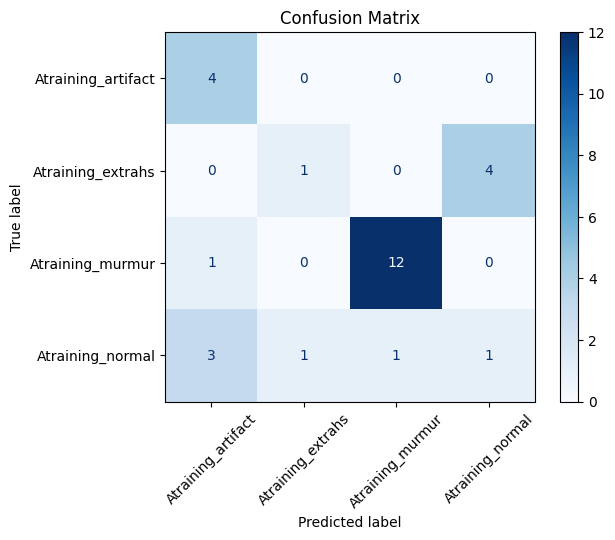

Epoch 1/20
3/3 [==============================] - 2s 363ms/step - loss: 6.2992 - accuracy: 0.4545 - val_loss: 4.1372 - val_accuracy: 0.3000
Epoch 2/20
3/3 [==============================] - 1s 315ms/step - loss: 3.6799 - accuracy: 0.5682 - val_loss: 4.1060 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 306ms/step - loss: 1.7175 - accuracy: 0.5795 - val_loss: 3.5039 - val_accuracy: 0.1000
Epoch 4/20
3/3 [==============================] - 1s 305ms/step - loss: 1.2466 - accuracy: 0.7500 - val_loss: 3.6071 - val_accuracy: 0.1000
Epoch 5/20
3/3 [==============================] - 1s 325ms/step - loss: 0.7027 - accuracy: 0.8295 - val_loss: 2.4312 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 1s 324ms/step - loss: 0.5532 - accuracy: 0.8409 - val_loss: 1.2416 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 1s 301ms/step - loss: 0.3141 - accuracy: 0.8636 - val_loss: 0.5251 - val_accuracy: 0.9000
Epoch 8/20
3/3 [

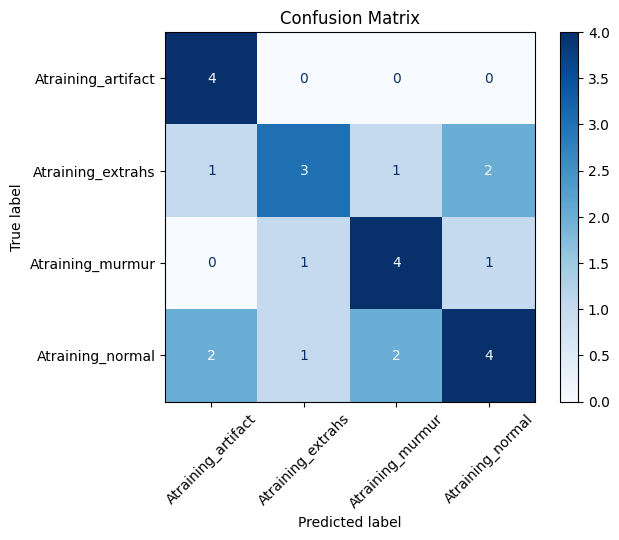

Epoch 1/20
3/3 [==============================] - 2s 362ms/step - loss: 7.9013 - accuracy: 0.2771 - val_loss: 29.1134 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 298ms/step - loss: 9.6130 - accuracy: 0.4337 - val_loss: 0.7289 - val_accuracy: 0.6000
Epoch 3/20
3/3 [==============================] - 1s 287ms/step - loss: 5.0391 - accuracy: 0.4578 - val_loss: 1.8126 - val_accuracy: 0.4000
Epoch 4/20
3/3 [==============================] - 1s 471ms/step - loss: 2.2124 - accuracy: 0.5904 - val_loss: 5.9345 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 459ms/step - loss: 1.4672 - accuracy: 0.7470 - val_loss: 7.0032 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 1s 415ms/step - loss: 1.1852 - accuracy: 0.7952 - val_loss: 4.5899 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 1s 465ms/step - loss: 0.7024 - accuracy: 0.8313 - val_loss: 2.8301 - val_accuracy: 0.2000
Epoch 8/20


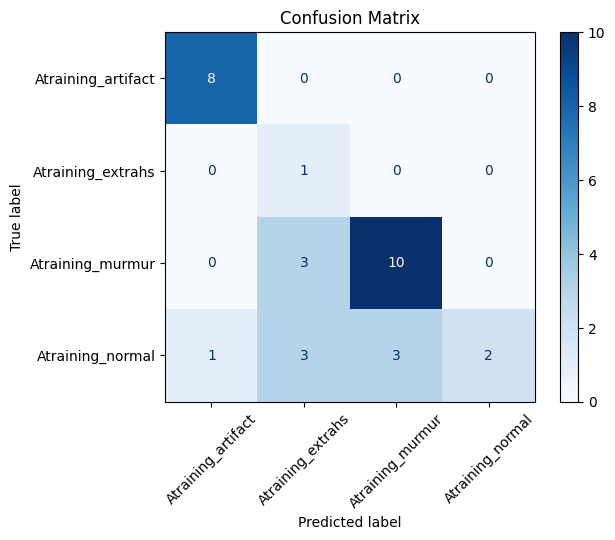

Epoch 1/20
3/3 [==============================] - 2s 413ms/step - loss: 4.0425 - accuracy: 0.4659 - val_loss: 14.9643 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 292ms/step - loss: 1.8894 - accuracy: 0.6932 - val_loss: 0.5361 - val_accuracy: 0.9000
Epoch 3/20
3/3 [==============================] - 1s 288ms/step - loss: 1.1594 - accuracy: 0.6023 - val_loss: 4.7891 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 297ms/step - loss: 0.8879 - accuracy: 0.7955 - val_loss: 6.2629 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 297ms/step - loss: 0.7457 - accuracy: 0.7955 - val_loss: 4.6256 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 296ms/step - loss: 0.5761 - accuracy: 0.8409 - val_loss: 2.5189 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 1s 299ms/step - loss: 0.3374 - accuracy: 0.9091 - val_loss: 2.3960 - val_accuracy: 0.1000
Epo

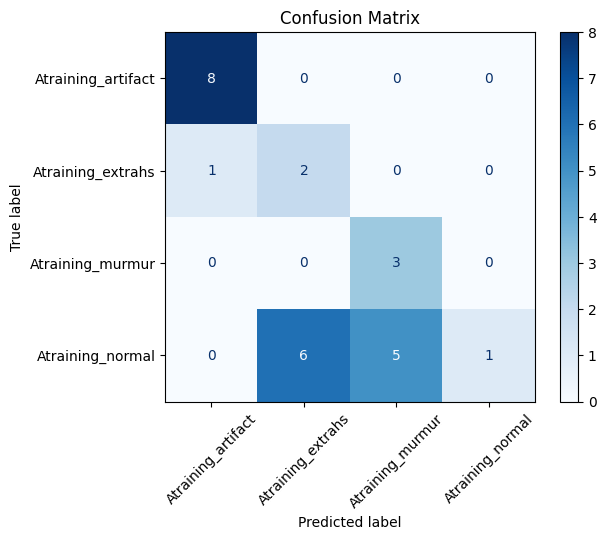

Epoch 1/20
3/3 [==============================] - 2s 378ms/step - loss: 14.0465 - accuracy: 0.3297 - val_loss: 23.1526 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 315ms/step - loss: 4.1256 - accuracy: 0.6374 - val_loss: 12.3537 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 317ms/step - loss: 2.3174 - accuracy: 0.6484 - val_loss: 2.9595 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 301ms/step - loss: 0.8624 - accuracy: 0.6374 - val_loss: 1.2746 - val_accuracy: 0.4545
Epoch 5/20
3/3 [==============================] - 1s 328ms/step - loss: 0.8897 - accuracy: 0.6374 - val_loss: 3.7845 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 299ms/step - loss: 0.7776 - accuracy: 0.7692 - val_loss: 4.0076 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 326ms/step - loss: 0.7719 - accuracy: 0.7582 - val_loss: 3.1562 - val_accuracy: 0.00

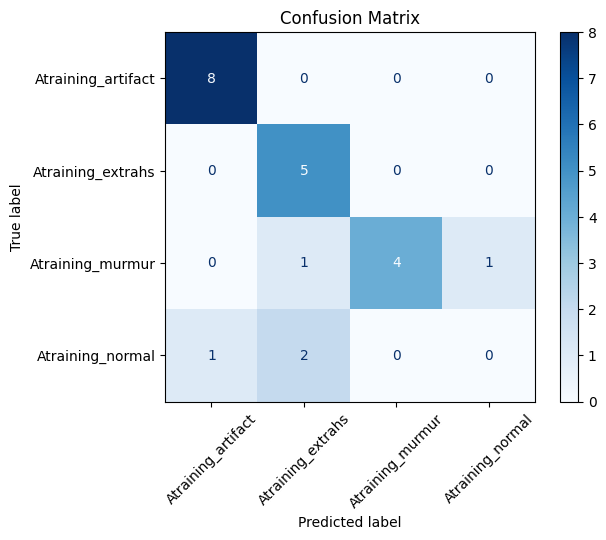

Epoch 1/20
3/3 [==============================] - 2s 389ms/step - loss: 9.2872 - accuracy: 0.4337 - val_loss: 12.9647 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 312ms/step - loss: 3.9823 - accuracy: 0.5663 - val_loss: 1.4356 - val_accuracy: 0.4000
Epoch 3/20
3/3 [==============================] - 1s 292ms/step - loss: 1.6462 - accuracy: 0.6867 - val_loss: 5.1495 - val_accuracy: 0.1000
Epoch 4/20
3/3 [==============================] - 1s 288ms/step - loss: 0.9847 - accuracy: 0.7349 - val_loss: 4.9979 - val_accuracy: 0.1000
Epoch 5/20
3/3 [==============================] - 1s 280ms/step - loss: 0.6914 - accuracy: 0.7108 - val_loss: 2.2089 - val_accuracy: 0.1000
Epoch 6/20
3/3 [==============================] - 1s 269ms/step - loss: 0.4791 - accuracy: 0.8554 - val_loss: 0.5376 - val_accuracy: 0.8000
Epoch 7/20
3/3 [==============================] - 1s 255ms/step - loss: 0.4463 - accuracy: 0.8554 - val_loss: 0.9708 - val_accuracy: 0.5000
Epoch 8/20
3/3 

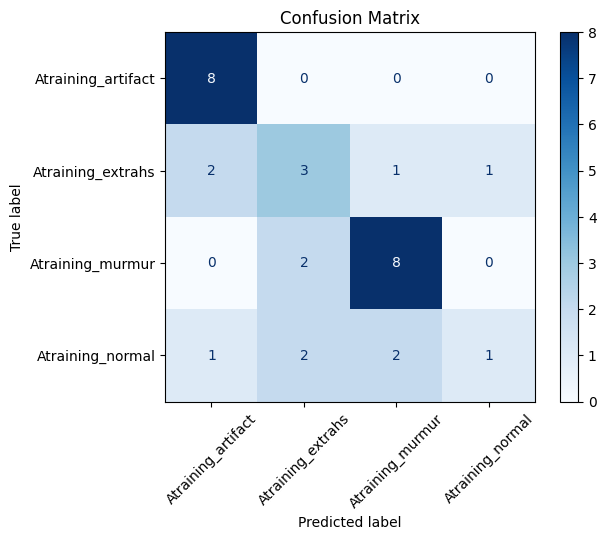

Epoch 1/20
3/3 [==============================] - 3s 351ms/step - loss: 8.8685 - accuracy: 0.3133 - val_loss: 14.1877 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 270ms/step - loss: 2.8806 - accuracy: 0.5904 - val_loss: 0.1367 - val_accuracy: 1.0000
Epoch 3/20
3/3 [==============================] - 1s 284ms/step - loss: 1.5811 - accuracy: 0.4699 - val_loss: 10.2122 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 308ms/step - loss: 1.8308 - accuracy: 0.7470 - val_loss: 11.1147 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 425ms/step - loss: 1.7279 - accuracy: 0.7229 - val_loss: 7.8072 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 1s 434ms/step - loss: 1.3129 - accuracy: 0.7831 - val_loss: 5.7108 - val_accuracy: 0.3000
Epoch 7/20
3/3 [==============================] - 1s 434ms/step - loss: 0.7210 - accuracy: 0.8193 - val_loss: 3.7183 - val_accuracy: 0.0000e+00
E

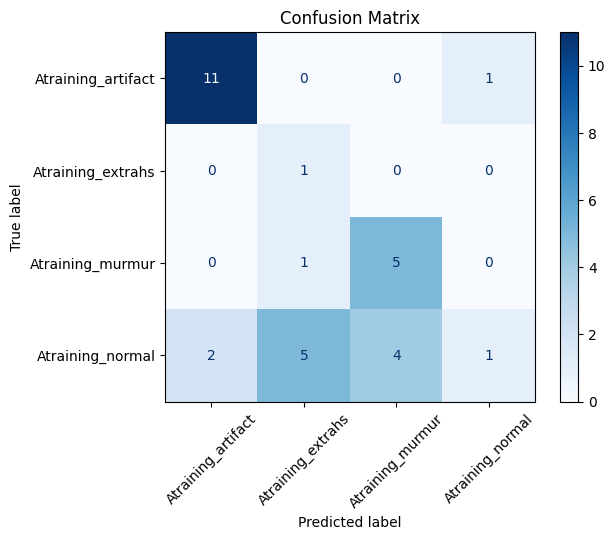

Epoch 1/20
3/3 [==============================] - 2s 379ms/step - loss: 6.2488 - accuracy: 0.2771 - val_loss: 6.4963 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 275ms/step - loss: 2.8404 - accuracy: 0.5422 - val_loss: 1.2396 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 302ms/step - loss: 1.5378 - accuracy: 0.5181 - val_loss: 2.0089 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 1s 280ms/step - loss: 0.8583 - accuracy: 0.7108 - val_loss: 1.1758 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 1s 281ms/step - loss: 0.7043 - accuracy: 0.7108 - val_loss: 1.9615 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 290ms/step - loss: 0.6370 - accuracy: 0.7470 - val_loss: 1.5656 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 1s 268ms/step - loss: 0.5054 - accuracy: 0.8675 - val_loss: 1.3431 - val_accuracy: 0.5000
Epoch 8/20
3

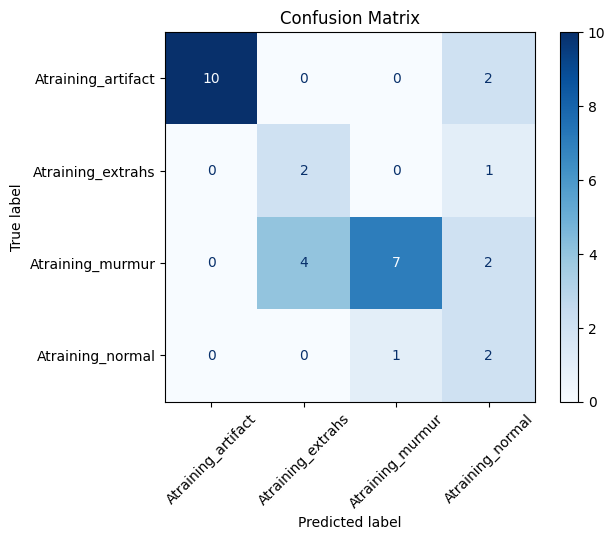

Epoch 1/20
3/3 [==============================] - 3s 540ms/step - loss: 12.3735 - accuracy: 0.4432 - val_loss: 15.9749 - val_accuracy: 0.1000
Epoch 2/20
3/3 [==============================] - 1s 346ms/step - loss: 11.7301 - accuracy: 0.5455 - val_loss: 2.8168 - val_accuracy: 0.1000
Epoch 3/20
3/3 [==============================] - 1s 280ms/step - loss: 7.3735 - accuracy: 0.3750 - val_loss: 2.1280 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 1s 290ms/step - loss: 3.3874 - accuracy: 0.6591 - val_loss: 2.3739 - val_accuracy: 0.7000
Epoch 5/20
3/3 [==============================] - 1s 289ms/step - loss: 2.9803 - accuracy: 0.7273 - val_loss: 3.0654 - val_accuracy: 0.2000
Epoch 6/20
3/3 [==============================] - 1s 296ms/step - loss: 2.2792 - accuracy: 0.6250 - val_loss: 2.4005 - val_accuracy: 0.3000
Epoch 7/20
3/3 [==============================] - 1s 309ms/step - loss: 0.9957 - accuracy: 0.6932 - val_loss: 1.5734 - val_accuracy: 0.6000
Epoch 8/20
3/3 [=

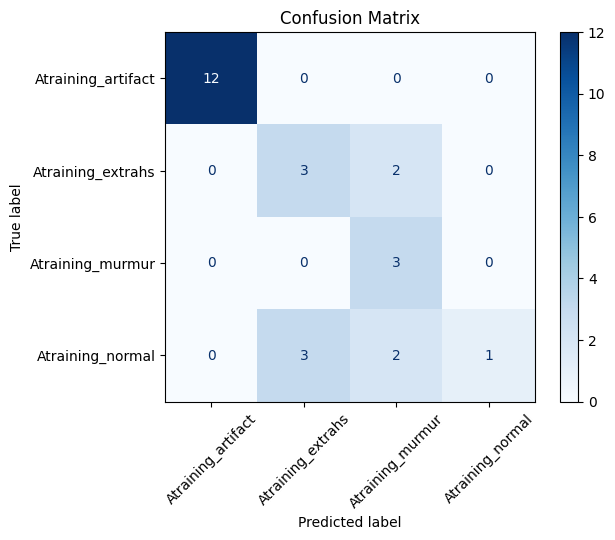

Epoch 1/20
3/3 [==============================] - 2s 481ms/step - loss: 7.8673 - accuracy: 0.4024 - val_loss: 1.1041 - val_accuracy: 0.8000
Epoch 2/20
3/3 [==============================] - 1s 473ms/step - loss: 4.3000 - accuracy: 0.4024 - val_loss: 5.0548 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 1s 413ms/step - loss: 2.0190 - accuracy: 0.4512 - val_loss: 2.4324 - val_accuracy: 0.6000
Epoch 4/20
3/3 [==============================] - 1s 412ms/step - loss: 1.4408 - accuracy: 0.5488 - val_loss: 1.4883 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 1s 420ms/step - loss: 1.0248 - accuracy: 0.6951 - val_loss: 2.1030 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 1s 285ms/step - loss: 0.8195 - accuracy: 0.7927 - val_loss: 1.9815 - val_accuracy: 0.2000
Epoch 7/20
3/3 [==============================] - 1s 281ms/step - loss: 0.5304 - accuracy: 0.8293 - val_loss: 1.4147 - val_accuracy: 0.2000
Epoch 8/20
3/3 [

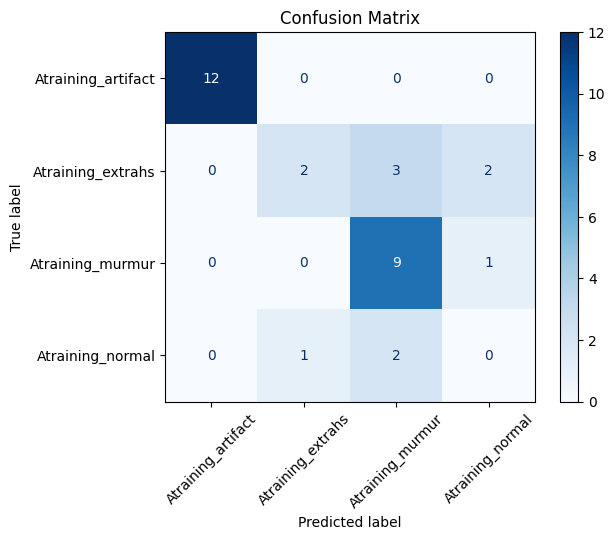

Epoch 1/20
3/3 [==============================] - 2s 393ms/step - loss: 6.9449 - accuracy: 0.3333 - val_loss: 7.3744 - val_accuracy: 0.3000
Epoch 2/20
3/3 [==============================] - 1s 291ms/step - loss: 3.3151 - accuracy: 0.4568 - val_loss: 5.5311 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 1s 284ms/step - loss: 1.5226 - accuracy: 0.7284 - val_loss: 11.7344 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 258ms/step - loss: 1.4591 - accuracy: 0.7284 - val_loss: 7.6219 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 1s 302ms/step - loss: 1.0034 - accuracy: 0.7654 - val_loss: 5.7091 - val_accuracy: 0.2000
Epoch 6/20
3/3 [==============================] - 1s 273ms/step - loss: 0.6704 - accuracy: 0.8519 - val_loss: 3.9294 - val_accuracy: 0.1000
Epoch 7/20
3/3 [==============================] - 1s 301ms/step - loss: 0.4636 - accuracy: 0.8519 - val_loss: 0.8398 - val_accuracy: 0.6000
Epoch 8/20
3/3 

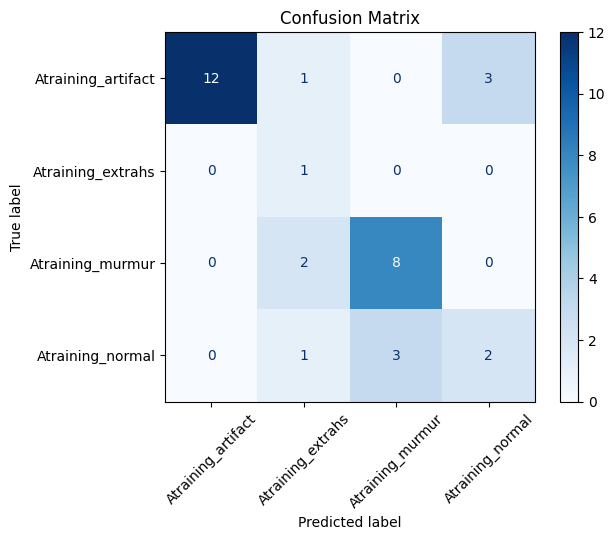

Epoch 1/20
3/3 [==============================] - 3s 572ms/step - loss: 8.1897 - accuracy: 0.4938 - val_loss: 4.8433 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 431ms/step - loss: 3.5261 - accuracy: 0.4444 - val_loss: 11.9577 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 2s 489ms/step - loss: 2.5775 - accuracy: 0.5802 - val_loss: 7.2858 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 374ms/step - loss: 1.9092 - accuracy: 0.5926 - val_loss: 0.5776 - val_accuracy: 0.7778
Epoch 5/20
3/3 [==============================] - 1s 282ms/step - loss: 1.1103 - accuracy: 0.7531 - val_loss: 6.6197 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 1s 274ms/step - loss: 0.9055 - accuracy: 0.8025 - val_loss: 5.5371 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 266ms/step - loss: 0.5956 - accuracy: 0.8272 - val_loss: 1.5481 - val_accuracy: 0.4444

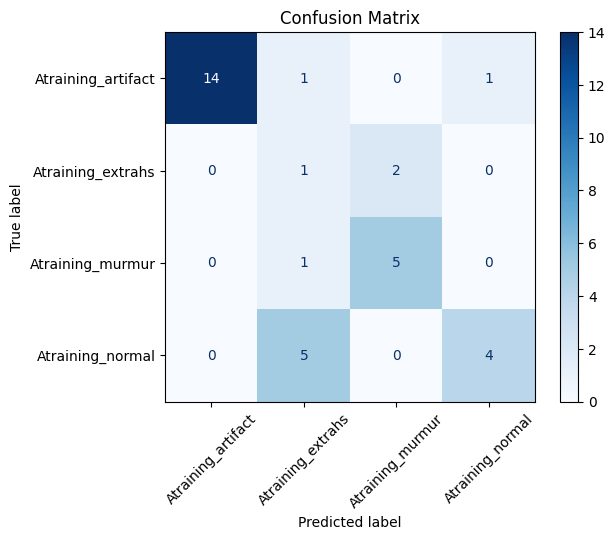

Epoch 1/20
3/3 [==============================] - 2s 341ms/step - loss: 6.6364 - accuracy: 0.5063 - val_loss: 14.8932 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 246ms/step - loss: 2.5660 - accuracy: 0.6203 - val_loss: 2.4999 - val_accuracy: 0.1111
Epoch 3/20
3/3 [==============================] - 1s 266ms/step - loss: 1.3139 - accuracy: 0.7848 - val_loss: 2.9468 - val_accuracy: 0.5556
Epoch 4/20
3/3 [==============================] - 1s 249ms/step - loss: 1.1316 - accuracy: 0.7975 - val_loss: 4.5987 - val_accuracy: 0.4444
Epoch 5/20
3/3 [==============================] - 1s 328ms/step - loss: 0.7761 - accuracy: 0.8228 - val_loss: 5.5576 - val_accuracy: 0.1111
Epoch 6/20
3/3 [==============================] - 1s 415ms/step - loss: 0.4918 - accuracy: 0.9367 - val_loss: 4.8454 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 1s 438ms/step - loss: 0.3113 - accuracy: 0.9241 - val_loss: 2.8359 - val_accuracy: 0.0000e+00
Epoch 8

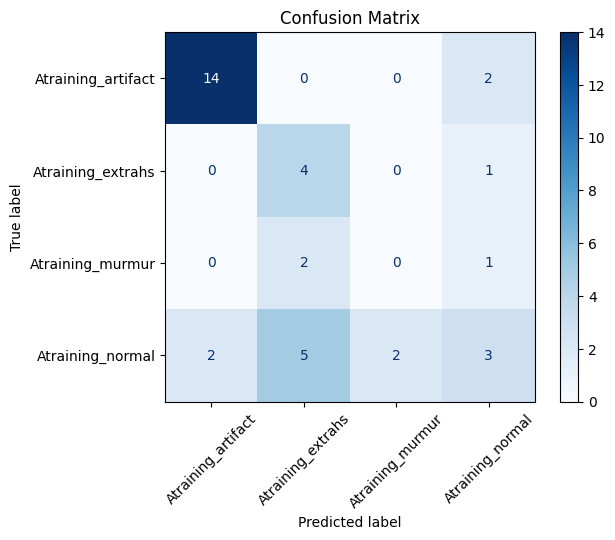

Epoch 1/20
3/3 [==============================] - 2s 313ms/step - loss: 7.7969 - accuracy: 0.3088 - val_loss: 15.2381 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 1s 234ms/step - loss: 6.7937 - accuracy: 0.5588 - val_loss: 7.4156 - val_accuracy: 0.1250
Epoch 3/20
3/3 [==============================] - 1s 347ms/step - loss: 3.2871 - accuracy: 0.6176 - val_loss: 15.6842 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 345ms/step - loss: 2.2114 - accuracy: 0.6471 - val_loss: 10.2053 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 1s 371ms/step - loss: 1.2354 - accuracy: 0.6471 - val_loss: 1.0356 - val_accuracy: 0.7500
Epoch 6/20
3/3 [==============================] - 1s 346ms/step - loss: 1.1756 - accuracy: 0.5735 - val_loss: 5.1046 - val_accuracy: 0.1250
Epoch 7/20
3/3 [==============================] - 1s 356ms/step - loss: 0.8311 - accuracy: 0.7353 - val_loss: 8.4329 - val_accuracy: 0.0000e+00
E

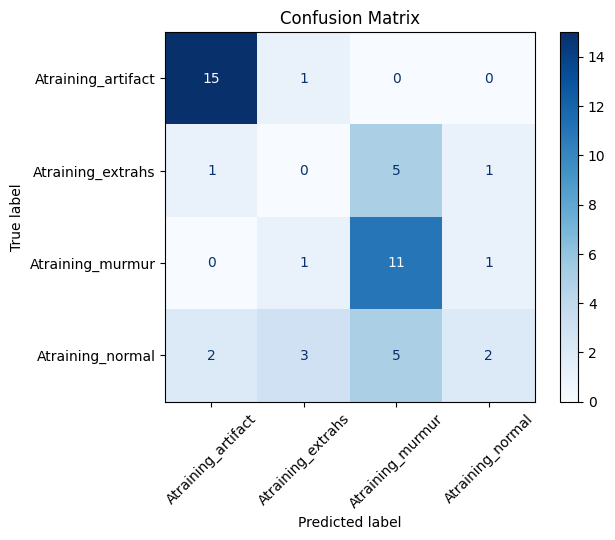

             Experiment  Atraining_artifact Precision  \
0  [0.1, 0.1, 0.1, 0.1]                      1.000000   
1  [0.1, 0.2, 0.3, 0.4]                      0.571429   
2  [0.1, 0.3, 0.4, 0.2]                      0.500000   
3  [0.1, 0.4, 0.2, 0.3]                      0.571429   
4  [0.2, 0.1, 0.4, 0.3]                      0.888889   

   Atraining_artifact Recall  Atraining_artifact F1-Score  \
0                       0.75                     0.857143   
1                       1.00                     0.727273   
2                       1.00                     0.666667   
3                       1.00                     0.727273   
4                       1.00                     0.941176   

   Atraining_extrahs Precision  Atraining_extrahs Recall  \
0                     1.000000                  1.000000   
1                     0.166667                  0.666667   
2                     0.500000                  0.200000   
3                     0.600000                  0.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import librosa
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import random

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Define your dataset directory and class labels
data_dir = '/content/drive/MyDrive/class_folder'  # Replace with your dataset directory
class_labels = ['Atraining_artifact','Atraining_extrahs','Atraining_murmur','Atraining_normal']  # Replace with your class labels
# Load data
data = []
labels = []
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, (128, 128))
        data.append(spectrogram)
        labels.append(class_labels.index(label))

data = np.array(data)
labels = np.array(labels)

# Simplified Taguchi L16 Orthogonal Array for 4 factors with 4 levels

# Custom Train-Test Split Function
def custom_train_test_split(data, labels, test_proportions, class_labels):
    X_train, X_test, y_train, y_test = [], [], [], []
    class_data = {i: [] for i in range(len(class_labels))}  # Use numeric keys for class_data

    for d, label in zip(data, labels):
        class_data[label].append(d)  # label should be an integer index

    for class_idx, proportion in enumerate(test_proportions):
        n_test_samples = int(proportion * len(class_data[class_idx]))
        n_train_samples = len(class_data[class_idx]) - n_test_samples

        np.random.shuffle(class_data[class_idx])
        X_test += class_data[class_idx][:n_test_samples]
        y_test += [class_idx] * n_test_samples
        X_train += class_data[class_idx][n_test_samples:]
        y_train += [class_idx] * n_train_samples

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


# CNN Model Function
def create_model(input_shape, num_classes):
    # model = models.Sequential([
    #     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Conv2D(64, (3, 3), activation='relu'),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Conv2D(128, (3, 3), activation='relu'),
    #     layers.GlobalAveragePooling2D(),
    #     layers.Dense(64, activation='relu'),
    #     layers.Dense(num_classes, activation='softmax')
    # ])

    model = models.Sequential([
      layers.Input(shape=X_train[0].shape),
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(len(class_labels), activation='softmax')])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize DataFrame for results
columns = ['Experiment'] + [f'{cls} {metric}' for cls in class_labels for metric in ['Precision', 'Recall', 'F1-Score']]
results_df = pd.DataFrame(columns=columns)
# Simplified Taguchi L16 Orthogonal Array for 4 factors with 4 levels
experiments = [
    [0.1, 0.1, 0.1, 0.1],  # Experiment 1
    [0.1, 0.2, 0.3, 0.4],  # Experiment 2
    [0.1, 0.3, 0.4, 0.2],  # Experiment 3
    [0.1, 0.4, 0.2, 0.3],  # Experiment 4
    [0.2, 0.1, 0.4, 0.3],  # Experiment 5
    [0.2, 0.2, 0.1, 0.4],  # Experiment 6
    [0.2, 0.3, 0.2, 0.1],  # Experiment 7
    [0.2, 0.4, 0.3, 0.2],  # Experiment 8
    [0.3, 0.1, 0.2, 0.4],  # Experiment 9
    [0.3, 0.2, 0.4, 0.1],  # Experiment 10
    [0.3, 0.3, 0.1, 0.2],  # Experiment 11
    [0.3, 0.4, 0.3, 0.1],  # Experiment 12
    [0.4, 0.1, 0.3, 0.2],  # Experiment 13
    [0.4, 0.2, 0.2, 0.3],  # Experiment 14
    [0.4, 0.3, 0.1, 0.4],  # Experiment 15
     [0.4, 0.4, 0.4, 0.4],  # Experiment 16
 ]
# Run experiments and store results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

for exp in experiments:
    X_train, X_test, y_train, y_test = custom_train_test_split(data, labels, exp, class_labels)
    X_train = (X_train - X_train.mean()) / X_train.std()
    X_test = (X_test - X_test.mean()) / X_test.std()

    model = create_model(X_train[0].shape, len(class_labels))
    model.fit(X_train, y_train, epochs=20, validation_split=0.1)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels, output_dict=True)
    model.fit(X_train, y_train, epochs=20, validation_split=0.1)

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test accuracy:", test_acc)
    # Predict class labels for the test set
    # y_pred = model.predict(X_test)
    # y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute the confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred_classes)

    # Create a ConfusionMatrixDisplay object and display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues, values_format='d',xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.savefig(f"Heartbeat classification using CNN_{str(exp)}.png")
    plt.show()

    # Add experiment results to DataFrame
    row = [str(exp)]
    for class_name in class_labels:
        class_metrics = classification_rep[class_name]
        row.extend([class_metrics['precision'], class_metrics['recall'], class_metrics['f1-score']])
    results_df.loc[len(results_df)] = row

# Display the final DataFrame
print(results_df.head())

# Optionally, save the final DataFrame to a new CSV file
results_df.to_csv('final_result_df.csv', index=False)



In [ ]:
result

In [ ]:
# Simplified Taguchi L16 Orthogonal Array for 4 factors with 4 levels
experiments = [
    [0.1, 0.1, 0.1, 0.1],  # Experiment 1
    [0.1, 0.2, 0.3, 0.4],  # Experiment 2
    [0.1, 0.3, 0.4, 0.2],  # Experiment 3
    [0.1, 0.4, 0.2, 0.3],  # Experiment 4
    [0.2, 0.1, 0.4, 0.3],  # Experiment 5
    [0.2, 0.2, 0.1, 0.4],  # Experiment 6
    [0.2, 0.3, 0.2, 0.1],  # Experiment 7
    [0.2, 0.4, 0.3, 0.2],  # Experiment 8
    [0.3, 0.1, 0.2, 0.4],  # Experiment 9
    [0.3, 0.2, 0.4, 0.1],  # Experiment 10
    [0.3, 0.3, 0.1, 0.2],  # Experiment 11
    [0.3, 0.4, 0.3, 0.1],  # Experiment 12
    [0.4, 0.1, 0.3, 0.2],  # Experiment 13
    [0.4, 0.2, 0.2, 0.3],  # Experiment 14
    [0.4, 0.3, 0.1, 0.4],  # Experiment 15
    [0.4, 0.4, 0.4, 0.4],  # Experiment 16
]

# Print the simplified Taguchi design experiments
print("Simplified Taguchi L16 Design Experiments:")
for exp in experiments:
    print(exp)


Simplified Taguchi L16 Design Experiments:
[0.1, 0.1, 0.1, 0.1]
[0.1, 0.2, 0.3, 0.4]
[0.1, 0.3, 0.4, 0.2]
[0.1, 0.4, 0.2, 0.3]
[0.2, 0.1, 0.4, 0.3]
[0.2, 0.2, 0.1, 0.4]
[0.2, 0.3, 0.2, 0.1]
[0.2, 0.4, 0.3, 0.2]
[0.3, 0.1, 0.2, 0.4]
[0.3, 0.2, 0.4, 0.1]
[0.3, 0.3, 0.1, 0.2]
[0.3, 0.4, 0.3, 0.1]
[0.4, 0.1, 0.3, 0.2]
[0.4, 0.2, 0.2, 0.3]
[0.4, 0.3, 0.1, 0.4]
[0.4, 0.4, 0.4, 0.4]


In [ ]:
# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Convert data to numpy arrays
# X_train = np.array(X_train)
# X_test = np.array(X_test)

# # Normalize the data
# X_train = (X_train - X_train.mean()) / X_train.std()
# X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d',xticks_rotation=45)
plt.title('Confusion Matrix')
plt.savefig("Heartbeat classification using CNN")
plt.show()
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
# plt.title('Confusion Matrix')
# plt.show()
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)

NameError: ignored

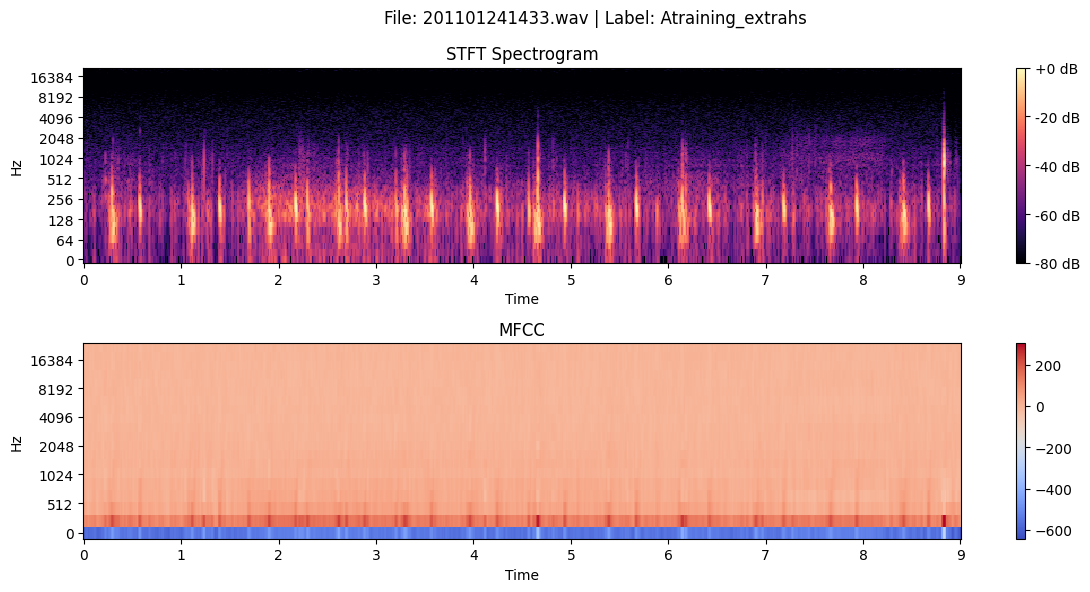

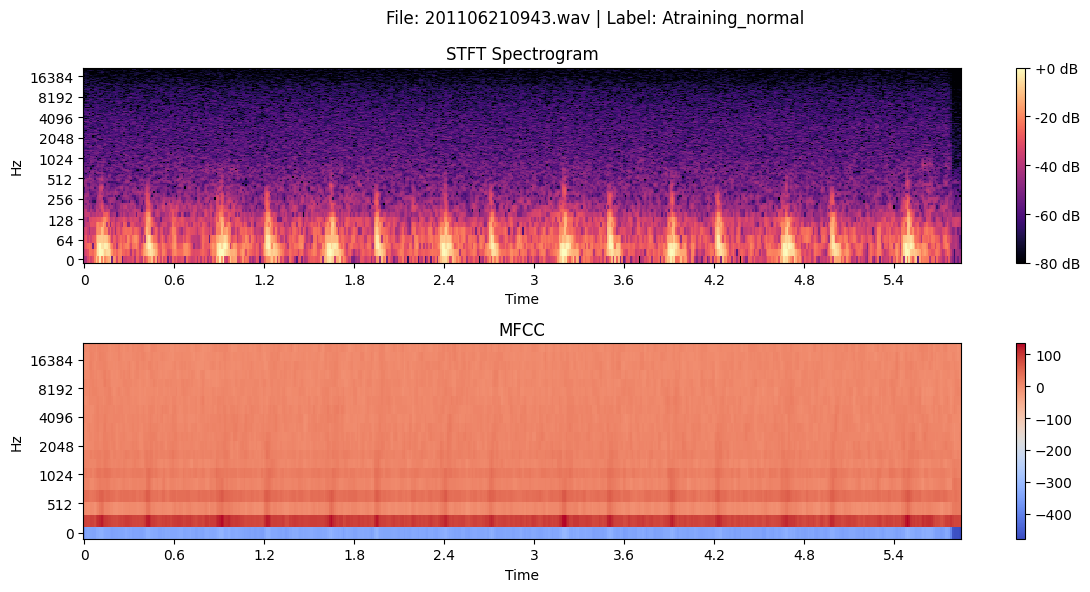

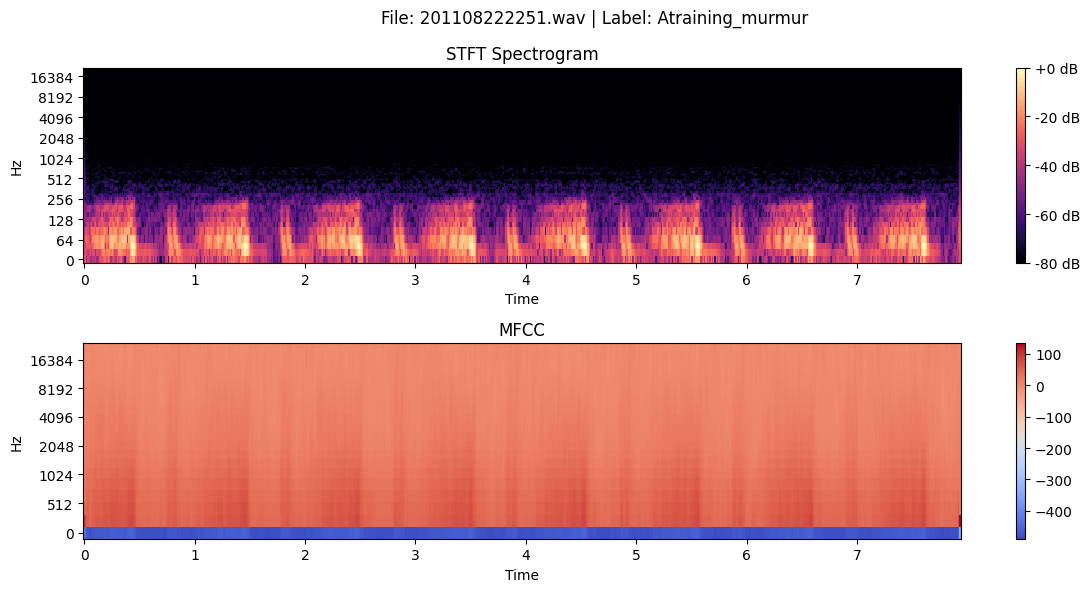

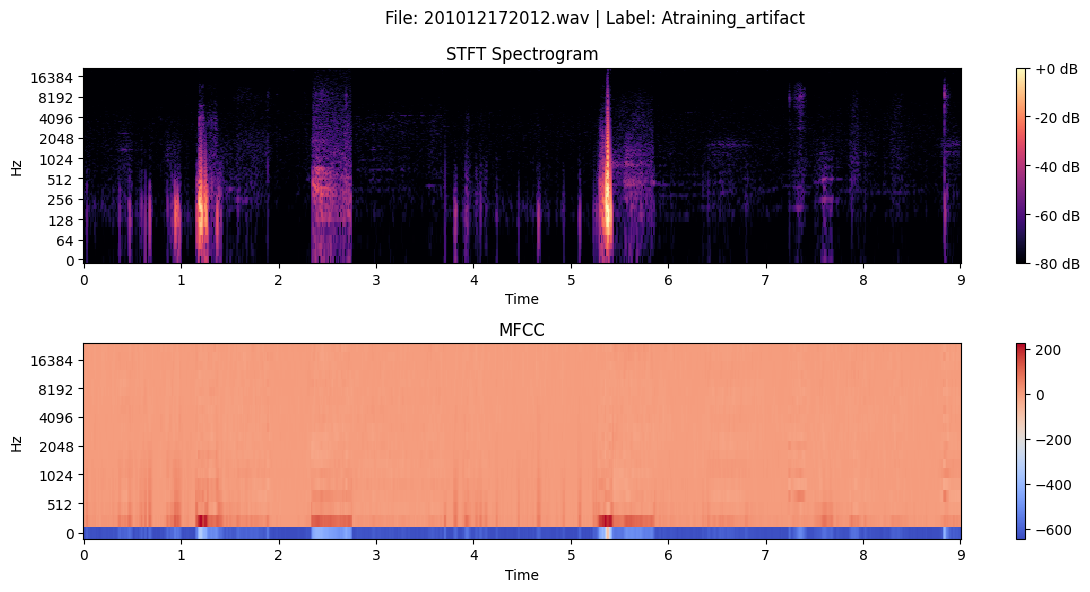

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to plot STFT and MFCC for a given audio file
def plot_stft_and_mfcc(file_path, label):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None)

    # Compute STFT
    stft = np.abs(librosa.stft(audio))
    stft_db = librosa.amplitude_to_db(stft, ref=np.max)

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot STFT
    plt.subplot(2, 1, 1)
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Spectrogram')

    # Plot MFCCs
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title('MFCC')

    # Set the plot title with file name and label
    plt.suptitle(f'File: {os.path.basename(file_path)} | Label: {label}')

    plt.tight_layout()
    plt.show()

# Specify the directory containing subfolders with audio files
base_dir = '/content/drive/MyDrive/class_folder'

# Get a list of subfolders (each representing a different label)
subfolders = [os.path.join(base_dir, folder) for folder in os.listdir(base_dir)]

# Iterate through subfolders
for subfolder in subfolders:
    # Get a list of audio files in the subfolder
    audio_files = [os.path.join(subfolder, file) for file in os.listdir(subfolder) if file.endswith('.wav')]

    # Randomly select an audio file from the subfolder
    if audio_files:
        random_audio_file = random.choice(audio_files)

        # Get the label (folder name)
        label = os.path.basename(subfolder)

        # Plot STFT and MFCC for the selected audio file with file name and label
        plot_stft_and_mfcc(random_audio_file, label)


Epoch 1/20
3/3 [==============================] - 1s 93ms/step - loss: 5.9570 - accuracy: 0.3258 - val_loss: 5.4830 - val_accuracy: 0.4000
Epoch 2/20
3/3 [==============================] - 0s 20ms/step - loss: 3.4329 - accuracy: 0.4607 - val_loss: 2.1956 - val_accuracy: 0.7000
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 2.2311 - accuracy: 0.6292 - val_loss: 2.5339 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 0s 21ms/step - loss: 1.3295 - accuracy: 0.6180 - val_loss: 2.7277 - val_accuracy: 0.3000
Epoch 5/20
3/3 [==============================] - 0s 20ms/step - loss: 1.0611 - accuracy: 0.7079 - val_loss: 1.7690 - val_accuracy: 0.3000
Epoch 6/20
3/3 [==============================] - 0s 20ms/step - loss: 0.8328 - accuracy: 0.6292 - val_loss: 1.1619 - val_accuracy: 0.6000
Epoch 7/20
3/3 [==============================] - 0s 19ms/step - loss: 0.7198 - accuracy: 0.7079 - val_loss: 1.0246 - val_accuracy: 0.5000
Epoch 8/20
3/3 [===========

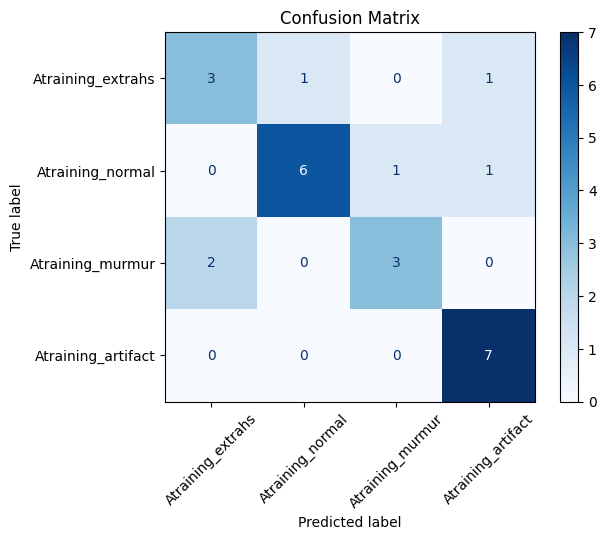

Classification Report:
                     precision    recall  f1-score   support

 Atraining_extrahs       0.60      0.60      0.60         5
  Atraining_normal       0.86      0.75      0.80         8
  Atraining_murmur       0.75      0.60      0.67         5
Atraining_artifact       0.78      1.00      0.88         7

          accuracy                           0.76        25
         macro avg       0.75      0.74      0.74        25
      weighted avg       0.76      0.76      0.75        25



In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
# data_dir = 'your_dataset_directory'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d',xticks_rotation=45)
plt.title('Confusion Matrix')
plt.savefig("Heartbeat classification using CNN")
plt.show()
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
# plt.title('Confusion Matrix')
# plt.show()
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)


Epoch 1/30
3/3 [==============================] - 2s 104ms/step - loss: 1.2789 - accuracy: 0.4045 - val_loss: 1.1710 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 0s 21ms/step - loss: 1.0643 - accuracy: 0.5618 - val_loss: 0.9576 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 0s 21ms/step - loss: 0.9457 - accuracy: 0.6180 - val_loss: 0.8771 - val_accuracy: 0.7000
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 0.7377 - accuracy: 0.7079 - val_loss: 0.7490 - val_accuracy: 0.7000
Epoch 5/30
3/3 [==============================] - 0s 20ms/step - loss: 0.6354 - accuracy: 0.7865 - val_loss: 0.8279 - val_accuracy: 0.6000
Epoch 6/30
3/3 [==============================] - 0s 20ms/step - loss: 0.5977 - accuracy: 0.7416 - val_loss: 0.8459 - val_accuracy: 0.7000
Epoch 7/30
3/3 [==============================] - 0s 20ms/step - loss: 0.5596 - accuracy: 0.7528 - val_loss: 0.6698 - val_accuracy: 0.6000
Epoch 8/30
3/3 [==========

1/1 [==============================] - 0s 80ms/step


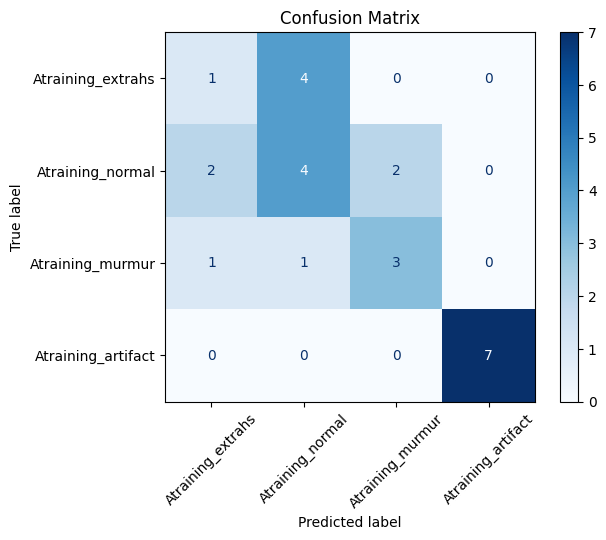

Classification Report:
                     precision    recall  f1-score   support

 Atraining_extrahs       0.25      0.20      0.22         5
  Atraining_normal       0.44      0.50      0.47         8
  Atraining_murmur       0.60      0.60      0.60         5
Atraining_artifact       1.00      1.00      1.00         7

          accuracy                           0.60        25
         macro avg       0.57      0.57      0.57        25
      weighted avg       0.59      0.60      0.60        25



In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    # Add a channel dimension to match the expected input shape
    spectrogram = spectrogram[..., np.newaxis]
    return spectrogram

# Specify your dataset directory
data_dir = '/content/drive/MyDrive/class_folder'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Build a different CNN model with more layers
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
plt.title('Confusion Matrix')
plt.show()

# Calculate and display classification report including precision, recall, f1-score
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)


Epoch 1/10
3/3 [==============================] - 3s 263ms/step - loss: 1.4055 - accuracy: 0.3371 - val_loss: 1.3903 - val_accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 0s 24ms/step - loss: 1.2742 - accuracy: 0.4157 - val_loss: 1.3305 - val_accuracy: 0.4000
Epoch 3/10
3/3 [==============================] - 0s 24ms/step - loss: 1.2684 - accuracy: 0.4607 - val_loss: 1.2719 - val_accuracy: 0.4000
Epoch 4/10
3/3 [==============================] - 0s 24ms/step - loss: 1.1692 - accuracy: 0.5169 - val_loss: 1.2427 - val_accuracy: 0.4000
Epoch 5/10
3/3 [==============================] - 0s 23ms/step - loss: 1.1357 - accuracy: 0.5506 - val_loss: 1.2220 - val_accuracy: 0.4000
Epoch 6/10
3/3 [==============================] - 0s 24ms/step - loss: 1.1113 - accuracy: 0.5730 - val_loss: 1.2206 - val_accuracy: 0.4000
Epoch 7/10
3/3 [==============================] - 0s 23ms/step - loss: 1.0689 - accuracy: 0.6180 - val_loss: 1.2220 - val_accuracy: 0.4000
Epoch 8/10
3/3 [==========

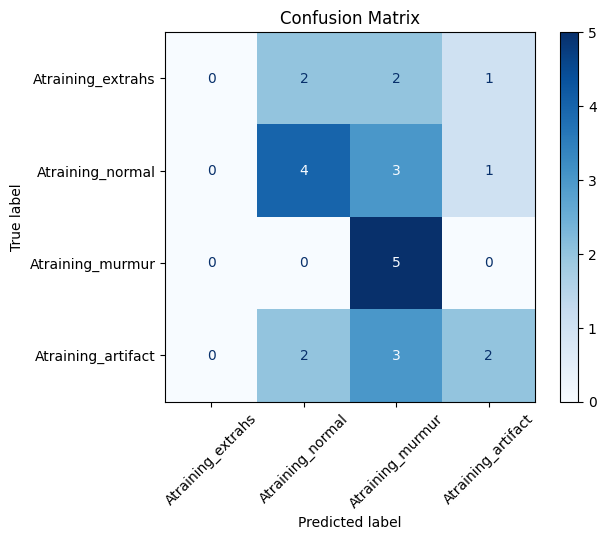

Classification Report:
                     precision    recall  f1-score   support

 Atraining_extrahs       0.00      0.00      0.00         5
  Atraining_normal       0.50      0.50      0.50         8
  Atraining_murmur       0.38      1.00      0.56         5
Atraining_artifact       0.50      0.29      0.36         7

          accuracy                           0.44        25
         macro avg       0.35      0.45      0.35        25
      weighted avg       0.38      0.44      0.37        25



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Function to extract features from an audio file and return a spectrogram
def extract_features(file_path, desired_shape):
    audio, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to the desired shape
    spectrogram = cv2.resize(spectrogram, desired_shape)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

# Specify your dataset directory
# data_dir = 'your_dataset_directory'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Reshape the data to have a sequence of spectrogram frames
n_frames = X_train.shape[1]
X_train = X_train.reshape(-1, n_frames, X_train.shape[2])
X_test = X_test.reshape(-1, n_frames, X_test.shape[2])

# Build an LSTM-based model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.LSTM(64),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

# Predict class labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Create a ConfusionMatrixDisplay object with rotated labels and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation=45)  # Rotate the labels at 45 degrees
plt.title('Confusion Matrix')
plt.show()

# Calculate and display classification report including precision, recall, f1-score
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", classification_rep)


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import make_scorer, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Function to create an LSTM-based model
def create_lstm_model(learning_rate=0.001, lstm_units=64):
    model = models.Sequential([
        layers.Input(shape=X_train[0].shape),
        layers.LSTM(lstm_units),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_labels), activation='softmax')
    ])

    # Compile the model with the specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Custom scoring function based on accuracy
def custom_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Specify your dataset directory
# data_dir = 'your_dataset_directory'

# Define your class labels based on subfolder names
class_labels = os.listdir(data_dir)

# Create a list to store spectrogram data and corresponding labels
data = []
labels = []

# Define the desired spectrogram shape
desired_shape = (128, 128)  # Adjust the shape as needed

# Iterate through each class label (subfolder)
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for audio_file in os.listdir(label_dir):
        audio_path = os.path.join(label_dir, audio_file)
        spectrogram = extract_features(audio_path, desired_shape)
        data.append(spectrogram)
        labels.append(class_labels.index(label))

# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Reshape the data to have a sequence of spectrogram frames
n_frames = X_train.shape[1]
X_train = X_train.reshape(-1, n_frames, X_train.shape[2])
X_test = X_test.reshape(-1, n_frames, X_test.shape[2])

# Define hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
lstm_units_values = [32, 64, 128]

best_accuracy = 0.0
best_hyperparameters = {}

# Iterate over hyperparameter combinations
for learning_rate in learning_rates:
    for lstm_units in lstm_units_values:
        print(f"Training model with learning_rate={learning_rate} and lstm_units={lstm_units}...")

        # Create an LSTM model with the current hyperparameters
        model = create_lstm_model(learning_rate=learning_rate, lstm_units=lstm_units)

        # Train the model
        model.fit(X_train, y_train, epochs=20, verbose=0)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate accuracy
        current_accuracy = custom_accuracy(y_test, y_pred_classes)

        # Check if the current model is the best so far
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_hyperparameters = {'learning_rate': learning_rate, 'lstm_units': lstm_units}

        print(f"Accuracy for learning_rate={learning_rate}, lstm_units={lstm_units}: {current_accuracy}")

print("Best hyperparameters:", best_hyperparameters)
print("Best accuracy:", best_accuracy)


Training model with learning_rate=0.001 and lstm_units=32...
1/1 [==============================] - 0s 348ms/step
Accuracy for learning_rate=0.001, lstm_units=32: 0.44
Training model with learning_rate=0.001 and lstm_units=64...
1/1 [==============================] - 0s 346ms/step
Accuracy for learning_rate=0.001, lstm_units=64: 0.44
Training model with learning_rate=0.001 and lstm_units=128...
1/1 [==============================] - 0s 350ms/step
Accuracy for learning_rate=0.001, lstm_units=128: 0.36
Training model with learning_rate=0.01 and lstm_units=32...
1/1 [==============================] - 0s 346ms/step
Accuracy for learning_rate=0.01, lstm_units=32: 0.44
Training model with learning_rate=0.01 and lstm_units=64...
1/1 [==============================] - 0s 344ms/step
Accuracy for learning_rate=0.01, lstm_units=64: 0.4
Training model with learning_rate=0.01 and lstm_units=128...
1/1 [==============================] - 0s 356ms/step
Accuracy for learning_rate=0.01, lstm_units=128: 